# Generating SQL for SQLite using Ollama, ChromaDB
This notebook runs through the process of using the `vanna` Python package to generate SQL using AI (RAG + LLMs) including connecting to a database and training. If you're not ready to train on your own database, you can still try it using a sample [SQLite database](app.md).

## Setup

In [1]:
from api_key_store import ApiKeyStore
s = ApiKeyStore()
api_key = s.get_api_key("OPENAI/Yiwen")
# print(openai_api_key)

In [2]:
import warnings
import re

warnings.filterwarnings('ignore', category=DeprecationWarning, message='^Number of requested results')
# warnings.filterwarnings('ignore', category=DeprecationWarning, message=re.escape(r'^Some regex pattern'))

import os

import re
from time import time
from datetime import datetime 

# from vanna.ollama import Ollama
from vanna.openai import OpenAI_Chat
from vanna.chromadb.chromadb_vector import ChromaDB_VectorStore

In [3]:
model_name = "gpt-4o" # 'gpt-4'  # 'gpt-3.5-turbo'
file_db = "~/Downloads/chinook.sqlite"

CONFIG = {
    'model': model_name,   # 'mistral' # "starcoder2"
    'api_key': api_key,     
}

file_db = "~/Downloads/datasets/chinook.db"

clean_and_train = True  # False  

sql_id = 1
NUM_RETRY = 3

In [4]:
class MyVanna(ChromaDB_VectorStore, OpenAI_Chat):
    def __init__(self, config=None):
        ChromaDB_VectorStore.__init__(self, config=config)
        OpenAI_Chat.__init__(self, config=config)
        

In [5]:
def remove_collections(collection_name=None, ACCEPTED_TYPES = ["sql", "ddl", "documentation"]):
    if not collection_name:
        collections = ACCEPTED_TYPES
    elif isinstance(collection_name, str):
        collections = [collection_name]
    elif isinstance(collection_name, list):
        collections = collection_name
    else:
        print(f"\t{collection_name} is unknown: Skipped")
        return

    for c in collections:
        if not c in ACCEPTED_TYPES:
            print(f"\t{c} is unknown: Skipped")
            continue
            
        # print(f"vn.remove_collection('{c}')")
        vn.remove_collection(c)

def strip_brackets(ddl):
    """
    This function removes square brackets from table and column names in a DDL script.
    
    Args:
        ddl (str): The DDL script containing square brackets.
    
    Returns:
        str: The DDL script with square brackets removed.
    """
    # Use regular expressions to match and replace square brackets
    pattern = r"\[([^\]]+)]"  # Match any character except ] within square brackets
    return re.sub(pattern, r"\1", ddl)

In [6]:
vn = MyVanna(config=CONFIG)

In [7]:
hostname = os.uname().nodename
print("Hostname:", hostname)

Hostname: ducklover1


In [8]:
file_db = os.path.abspath(os.path.expanduser(file_db))
vn.connect_to_sqlite(file_db)

In [9]:
vn.run_sql_is_set

True

In [10]:
if clean_and_train:
    remove_collections()

## Training
You only need to train once. Do not train again unless you want to add more training data.

In [11]:
# show training data
training_data = vn.get_training_data()
training_data

,id,question,content,training_data_type


In [12]:
df_ddl = vn.run_sql("SELECT type, sql FROM sqlite_master WHERE sql is not null")

In [13]:
df_ddl

,type,sql
0,table,"CREATE TABLE ""albums""\r\n(\r\n [AlbumId] IN..."
1,table,"CREATE TABLE sqlite_sequence(name,seq)"
2,table,"CREATE TABLE ""artists""\r\n(\r\n [ArtistId] ..."
3,table,"CREATE TABLE ""customers""\r\n(\r\n [Customer..."
4,table,"CREATE TABLE ""employees""\r\n(\r\n [Employee..."
5,table,"CREATE TABLE ""genres""\r\n(\r\n [GenreId] IN..."
6,table,"CREATE TABLE ""invoices""\r\n(\r\n [InvoiceId..."
7,table,"CREATE TABLE ""invoice_items""\r\n(\r\n [Invo..."
8,table,"CREATE TABLE ""media_types""\r\n(\r\n [MediaT..."
9,table,"CREATE TABLE ""playlists""\r\n(\r\n [Playlist..."


In [14]:
if clean_and_train:
    for ddl in df_ddl['sql'].to_list():
        ddl = strip_brackets(ddl)
        vn.train(ddl=ddl)

    # Sometimes you may want to add documentation about your business terminology or definitions.
    vn.train(documentation="In the chinook database invoice means order")

Adding ddl: CREATE TABLE "albums"
(
    AlbumId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
    Title NVARCHAR(160)  NOT NULL,
    ArtistId INTEGER  NOT NULL,
    FOREIGN KEY (ArtistId) REFERENCES "artists" (ArtistId) 
		ON DELETE NO ACTION ON UPDATE NO ACTION
)
Adding ddl: CREATE TABLE sqlite_sequence(name,seq)
Adding ddl: CREATE TABLE "artists"
(
    ArtistId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
    Name NVARCHAR(120)
)
Adding ddl: CREATE TABLE "customers"
(
    CustomerId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
    FirstName NVARCHAR(40)  NOT NULL,
    LastName NVARCHAR(20)  NOT NULL,
    Company NVARCHAR(80),
    Address NVARCHAR(70),
    City NVARCHAR(40),
    State NVARCHAR(40),
    Country NVARCHAR(40),
    PostalCode NVARCHAR(10),
    Phone NVARCHAR(24),
    Fax NVARCHAR(24),
    Email NVARCHAR(60)  NOT NULL,
    SupportRepId INTEGER,
    FOREIGN KEY (SupportRepId) REFERENCES "employees" (EmployeeId) 
		ON DELETE NO ACTION ON UPDATE NO ACTION
)
Adding ddl: CREATE TAB

## Asking the AI
Whenever you ask a new question, it will find the 10 most relevant pieces of training data and use it as part of the LLM prompt to generate the SQL.

### warm-up





# QUESTION :  How many customers are there


Using model gpt-4o for 944.5 tokens (approx)

[( EXTRACTED SQL )]
SELECT COUNT(*) AS NumberOfCustomers FROM customers;


[( <SQL> )]
generated SQL statement



SELECT COUNT(*) AS NumberOfCustomers FROM customers;


[( <DataFrame> )]
queried dataframe



,NumberOfCustomers
0,59


Using model gpt-4o for 168.75 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.graph_objects as go

fig = go.Figure(go.Indicator(
    mode = "number",
    value = df['NumberOfCustomers'][0],
    title = {"text": "Number of Customers"}
))

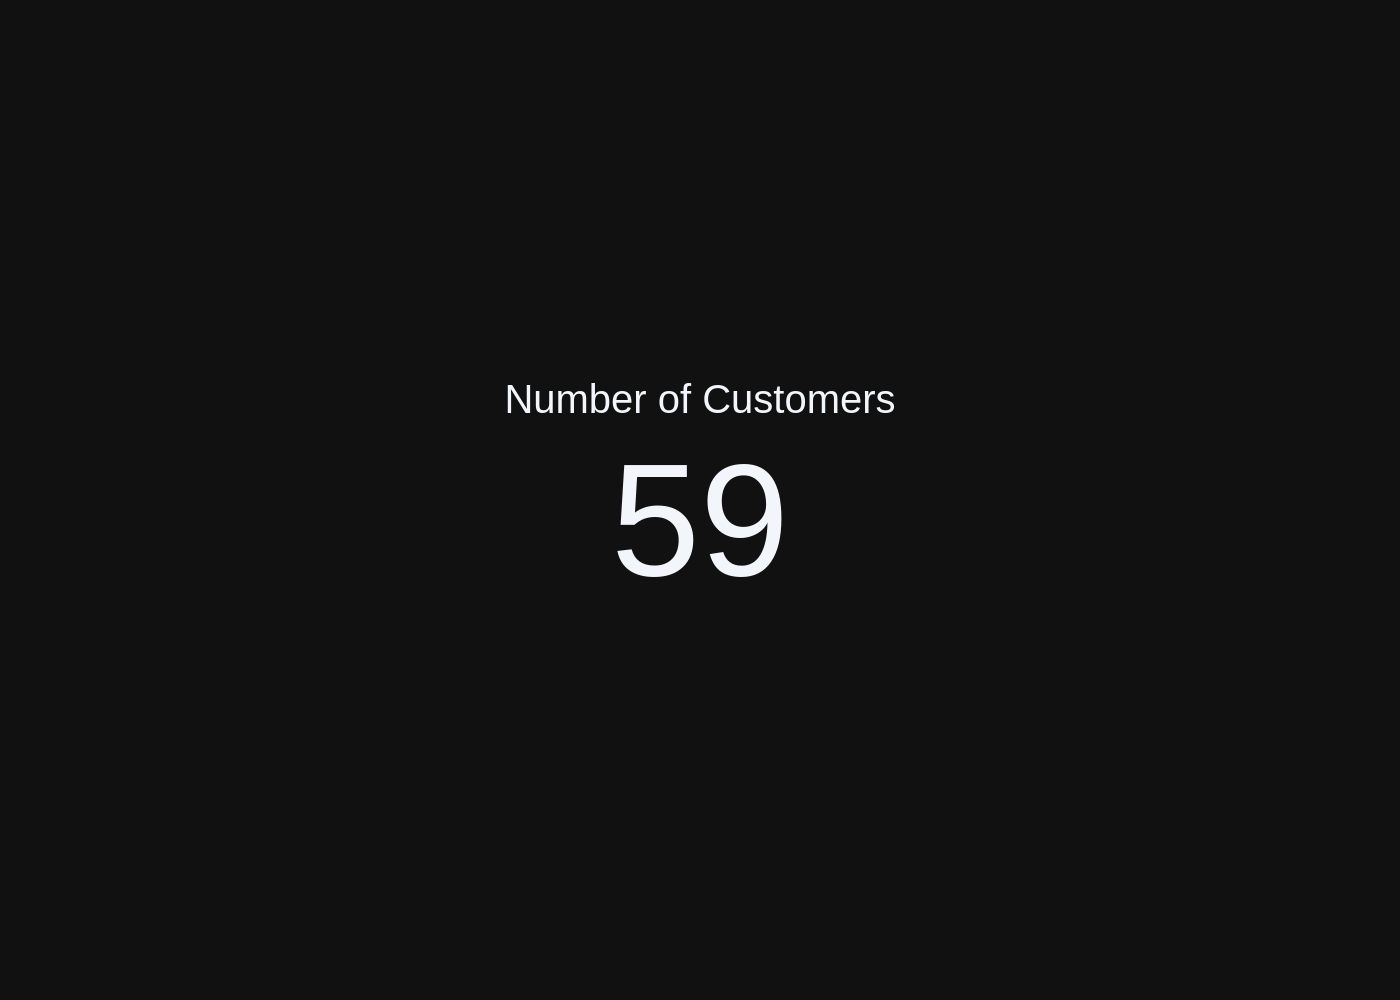

elapsed_time = 2.819166898727417


In [15]:
ts_start = time()
question = "How many customers are there"
resp = vn.ask_adaptive(question=question)
ts_stop = time()
elapsed_time = ts_stop - ts_start
print(f"elapsed_time = {elapsed_time}")

In [16]:
### Loop over questions

In [17]:
questions = [
    "Can you list all tables in the SQLite database catalog?",
    "which table stores customer's orders",
    "How many customers are there",
    "what are the top 5 countries that customers come from?",
    "List all albums and their corresponding artist names  ",
    """Find all tracks with a name containing "What" (case-insensitive) """,
    "Get the total number of invoices for each customer",
    "Find the total number of invoices per country",
    "List all invoices with a total exceeding $10",
    "Find all invoices since 2010 and the total amount invoiced:",
    "List all employees and their reporting manager's name (if any):",
    " Get the average invoice total for each customer:",
    "Find the top 5 most expensive tracks (based on unit price):",
    "List all genres and the number of tracks in each genre:",
    "Get all genres that do not have any tracks associated with them:",
    "List all customers who have not placed any orders:",
    """ 
        Can you find the top 10 most popular artists based on the number of tracks?
        Hint: There are 3 tables - artists, albums and tracks, 
        where albums and artists are linked by ArtistId, albums and tracks are linked by AlbumId,
    """,
    "List all customers from Canada and their email addresses:",
    "Find the customer with the most invoices ",
    "Find the customer who bought the most albums in total quantity (across all invoices):",
    """      
        Find the top 5 customers who bought the most albums in total quantity (across all invoices):
        Hint: album quantity is found in invoice_items, 
    """,
    """  
         Find the top 5 customers who spent the most money overall,  
         Hint: order total can be found on invoices table, calculation using invoice_items detail table is unnecessary 
    """,
    "Get all playlists containing at least 10 tracks and the total duration of those tracks:",
    "Identify artists who have albums with tracks appearing in multiple genres:",
]





# QUESTION  - 2:  Can you list all tables in the SQLite database catalog?


Using model gpt-4o for 867.0 tokens (approx)

[( EXTRACTED SQL )]
SELECT name FROM sqlite_master WHERE type='table';


[( <SQL> )]
generated SQL statement



SELECT name FROM sqlite_master WHERE type='table';


[( <DataFrame> )]
queried dataframe



,name
0,albums
1,sqlite_sequence
2,artists
3,customers
4,employees
5,genres
6,invoices
7,invoice_items
8,media_types
9,playlists


Using model gpt-4o for 172.0 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.graph_objects as go

if len(df) == 1:
    fig = go.Figure(go.Indicator(
        mode = "number",
        value = len(df),
        title = {"text": "Number of Tables"}
    ))
else:
    fig = go.Figure(go.Bar(
        x=df.index,
        y=df['name'],
        text=df['name'],
        textposition='auto'
    ))
    fig.update_layout(
        title="List of Tables in SQLite Database",
        xaxis_title="Index",
        yaxis_title="Table Name"
    )

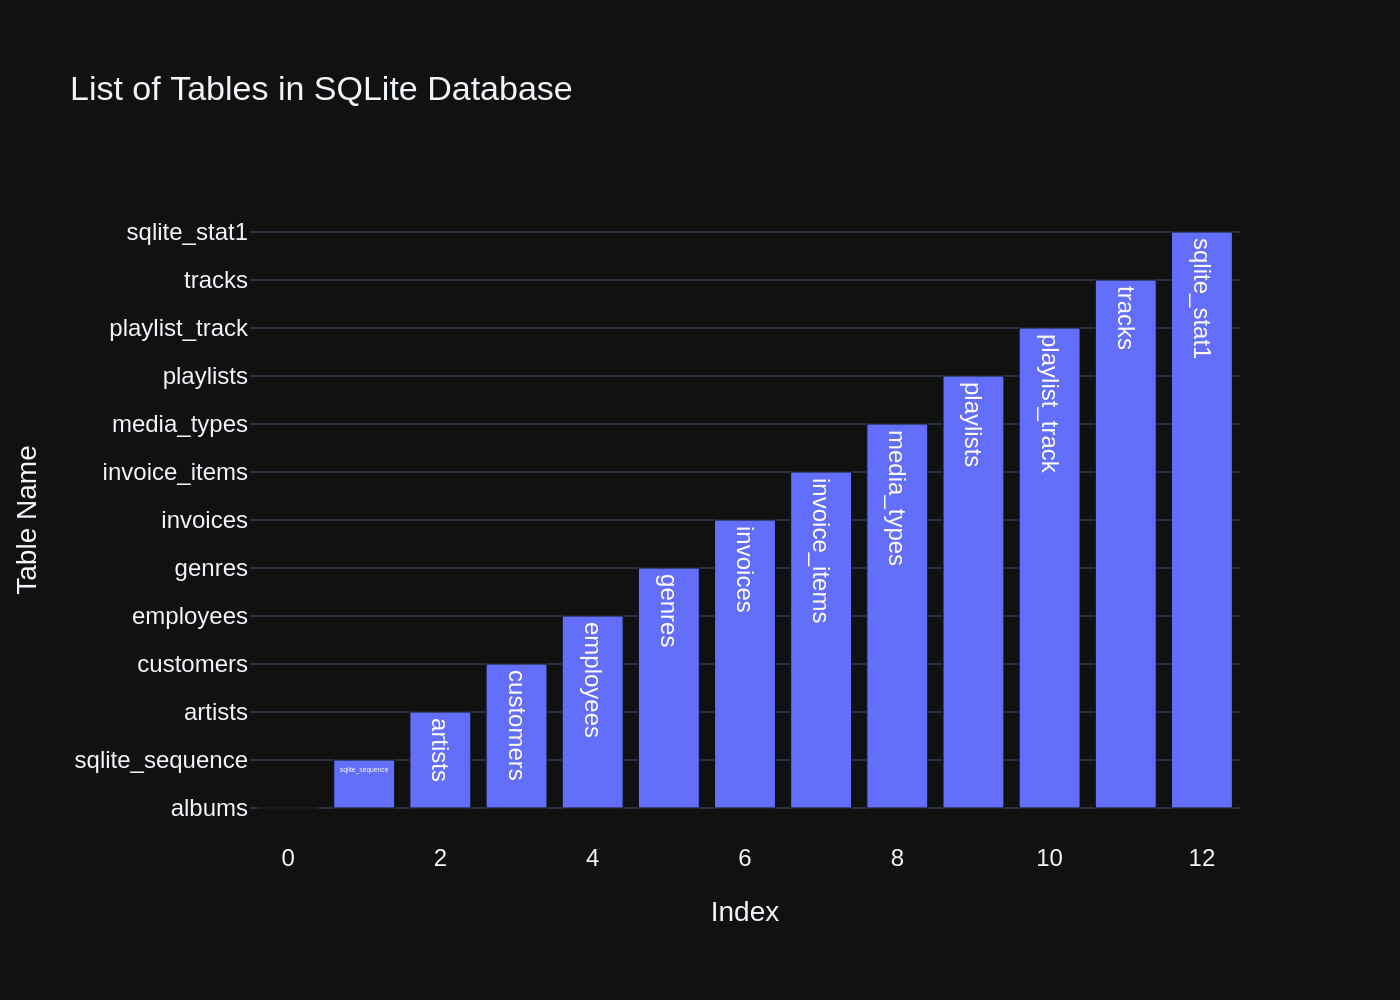





# QUESTION  - 3:  which table stores customer's orders


Using model gpt-4o for 1076.0 tokens (approx)

[( RETRY )]
***** 1 *****

Using model gpt-4o for 1060.0 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT name FROM sqlite_master WHERE type='table' AND name='invoices' LIMIT 20


[( <DataFrame> )]
queried dataframe



,name
0,invoices


Using model gpt-4o for 254.5 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.graph_objects as go

fig = go.Figure(go.Indicator(
    mode = "number",
    value = len(df),
    title = {"text": "Number of Tables"}
))

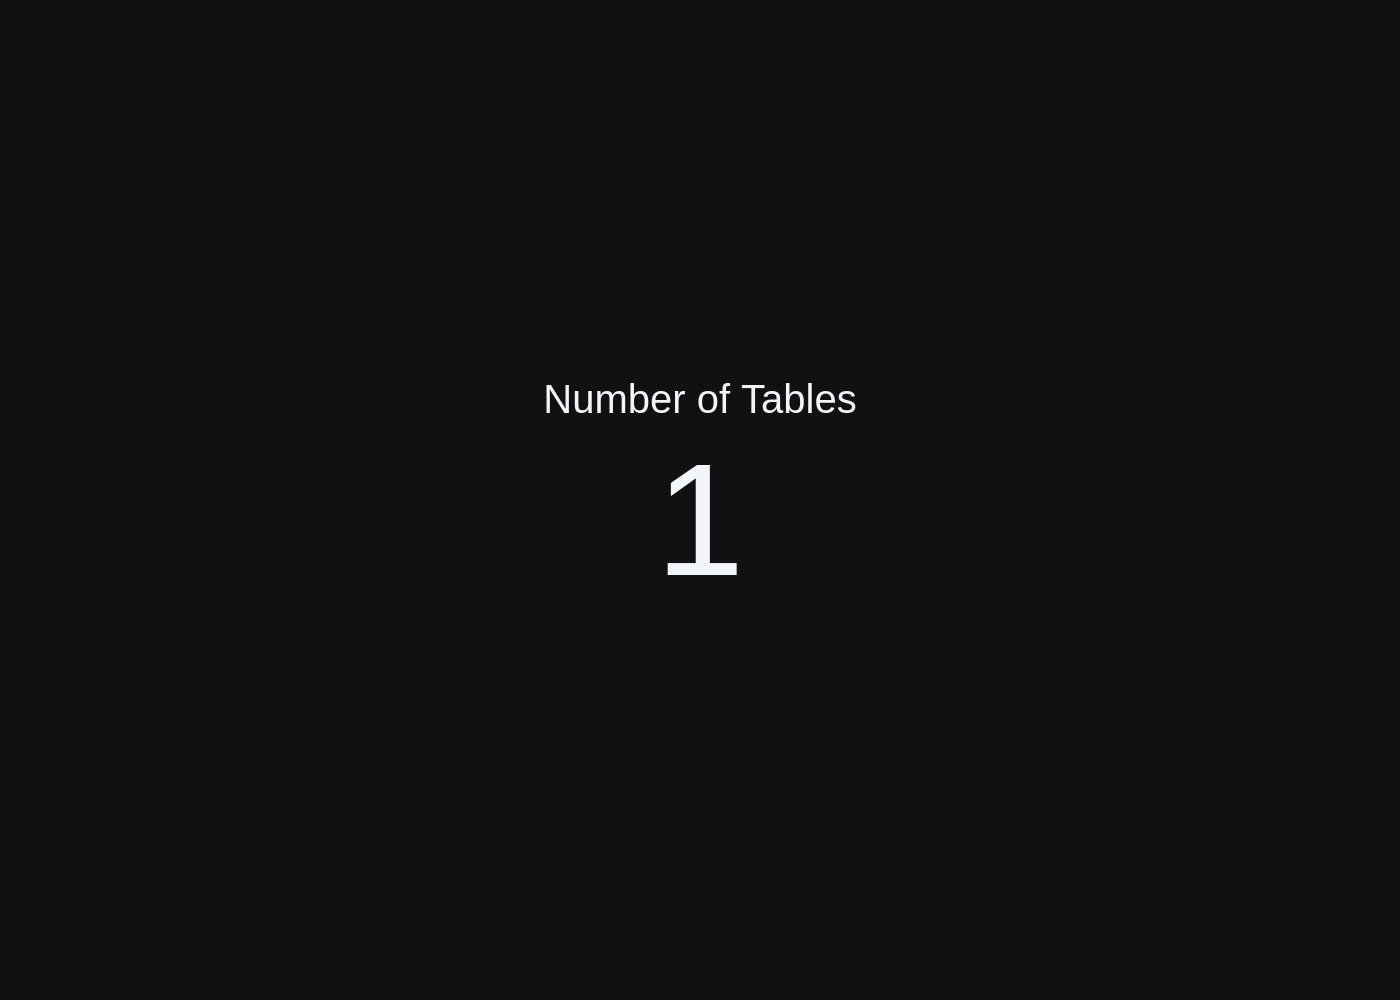





# QUESTION  - 4:  How many customers are there


Using model gpt-4o for 1105.5 tokens (approx)

[( EXTRACTED SQL )]
SELECT COUNT(*) AS NumberOfCustomers FROM customers;


[( <SQL> )]
generated SQL statement



SELECT COUNT(*) AS NumberOfCustomers FROM customers;


[( <DataFrame> )]
queried dataframe



,NumberOfCustomers
0,59


Using model gpt-4o for 168.75 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.graph_objects as go

fig = go.Figure(go.Indicator(
    mode = "number",
    value = df['NumberOfCustomers'].iloc[0],
    title = {"text": "Number of Customers"}
))

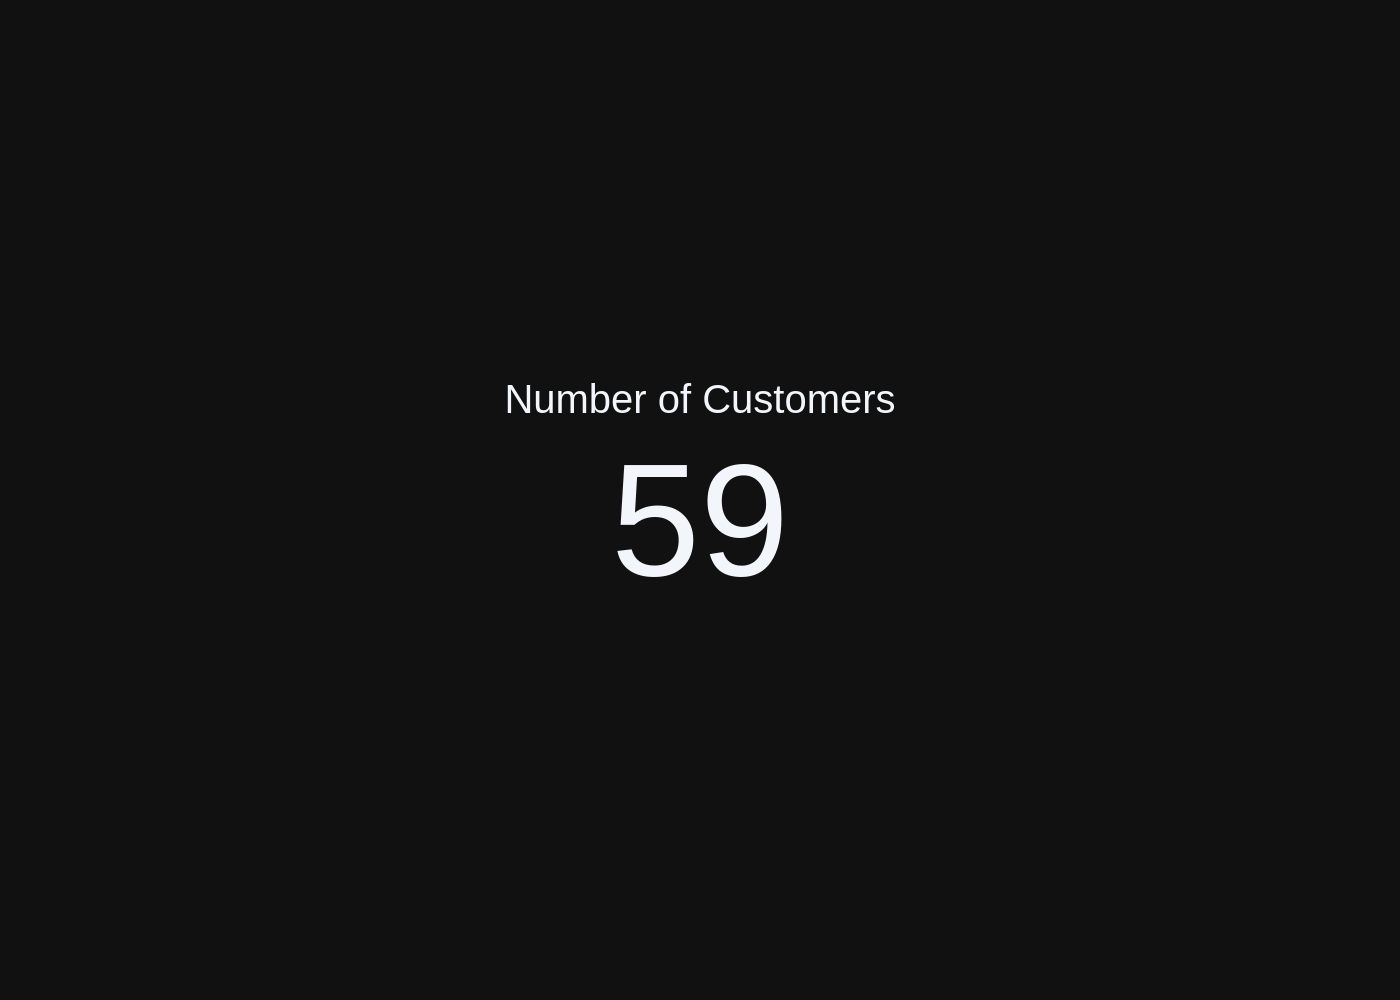





# QUESTION  - 5:  what are the top 5 countries that customers come from?


Using model gpt-4o for 1330.5 tokens (approx)

[( EXTRACTED SQL )]
SELECT Country, COUNT(*) AS NumberOfCustomers
FROM customers
GROUP BY Country
ORDER BY NumberOfCustomers DESC
LIMIT 5;


[( <SQL> )]
generated SQL statement



SELECT Country, COUNT(*) AS NumberOfCustomers
FROM customers
GROUP BY Country
ORDER BY NumberOfCustomers DESC
LIMIT 5;


[( <DataFrame> )]
queried dataframe



,Country,NumberOfCustomers
0,USA,13
1,Canada,8
2,France,5
3,Brazil,5
4,Germany,4


Using model gpt-4o for 197.0 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.express as px
import plotly.graph_objects as go

if len(df) == 1:
    fig = go.Figure(go.Indicator(
        mode = "number",
        value = df['NumberOfCustomers'].iloc[0],
        title = {"text": f"Customers from {df['Country'].iloc[0]}"}
    ))
else:
    fig = px.bar(df, x='Country', y='NumberOfCustomers', title='Top 5 Countries by Number of Customers')

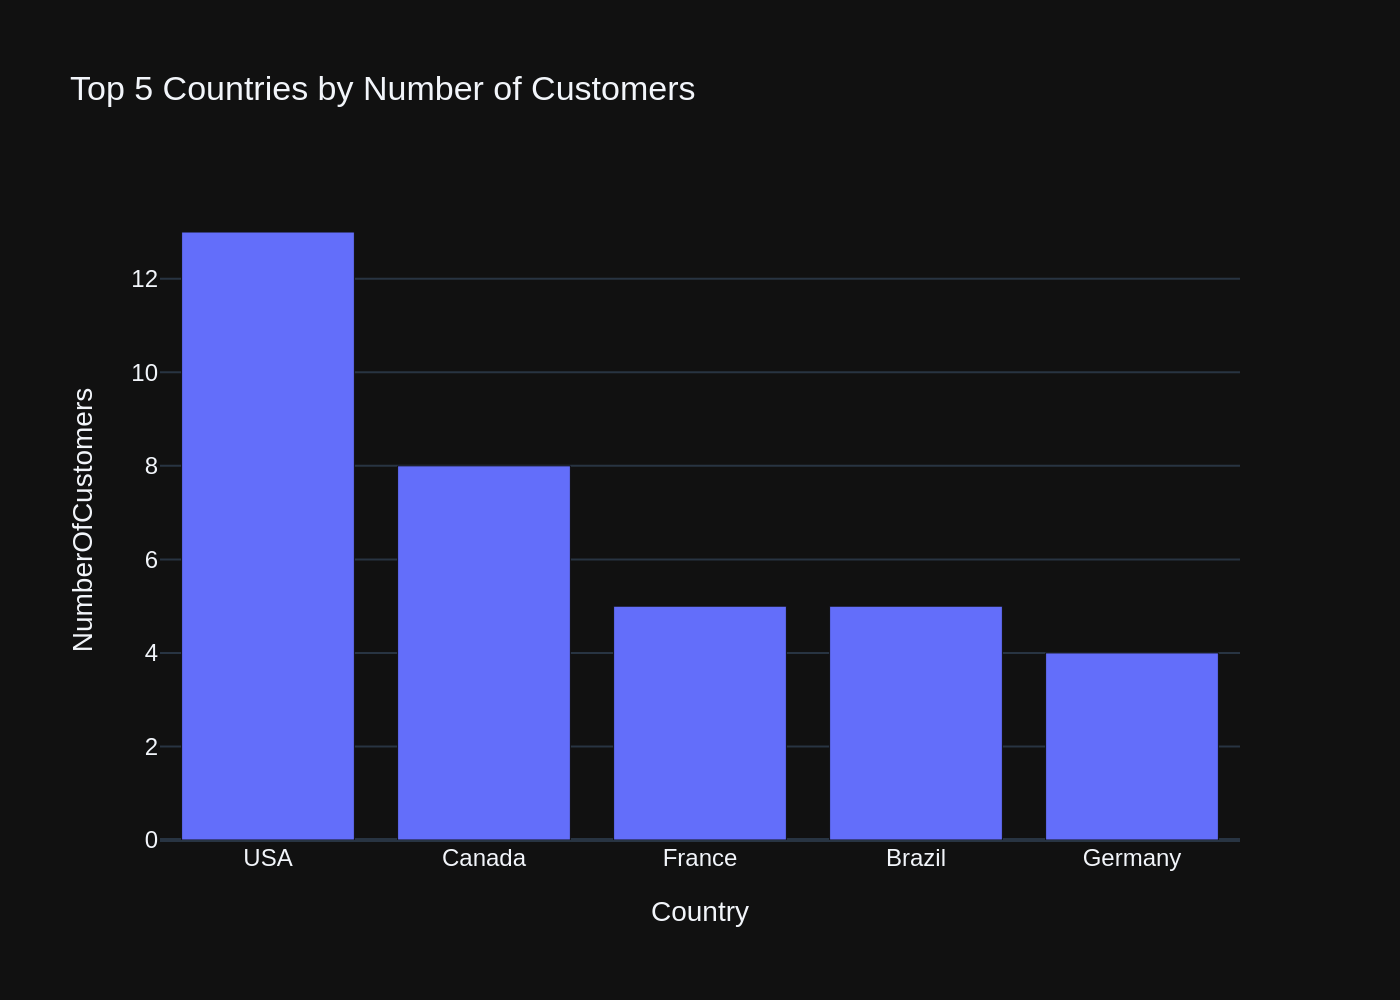





# QUESTION  - 6:  List all albums and their corresponding artist names  


Using model gpt-4o for 863.5 tokens (approx)

[( EXTRACTED SQL )]
SELECT albums.Title AS AlbumTitle, artists.Name AS ArtistName
FROM albums
JOIN artists ON albums.ArtistId = artists.ArtistId;


[( <SQL> )]
generated SQL statement



SELECT albums.Title AS AlbumTitle, artists.Name AS ArtistName
FROM albums
JOIN artists ON albums.ArtistId = artists.ArtistId;


[( <DataFrame> )]
queried dataframe



,AlbumTitle,ArtistName
0,For Those About To Rock We Salute You,AC/DC
1,Balls to the Wall,Accept
2,Restless and Wild,Accept
3,Let There Be Rock,AC/DC
4,Big Ones,Aerosmith
5,Jagged Little Pill,Alanis Morissette
6,Facelift,Alice In Chains
7,Warner 25 Anos,Antônio Carlos Jobim
8,Plays Metallica By Four Cellos,Apocalyptica
9,Audioslave,Audioslave


Using model gpt-4o for 197.25 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.express as px
import plotly.graph_objects as go

if len(df) == 1:
    fig = go.Figure(go.Indicator(
        mode = "number",
        value = 1,
        title = {"text": f"Album: {df.iloc[0]['AlbumTitle']}<br>Artist: {df.iloc[0]['ArtistName']}"}
    ))
else:
    fig = px.bar(df, x='AlbumTitle', y='ArtistName', orientation='h', 
                 labels={'AlbumTitle': 'Album Title', 'ArtistName': 'Artist Name'},
                 title='Albums and Their Corresponding Artists')
    fig.update_layout(yaxis={'categoryorder':'total ascending'})

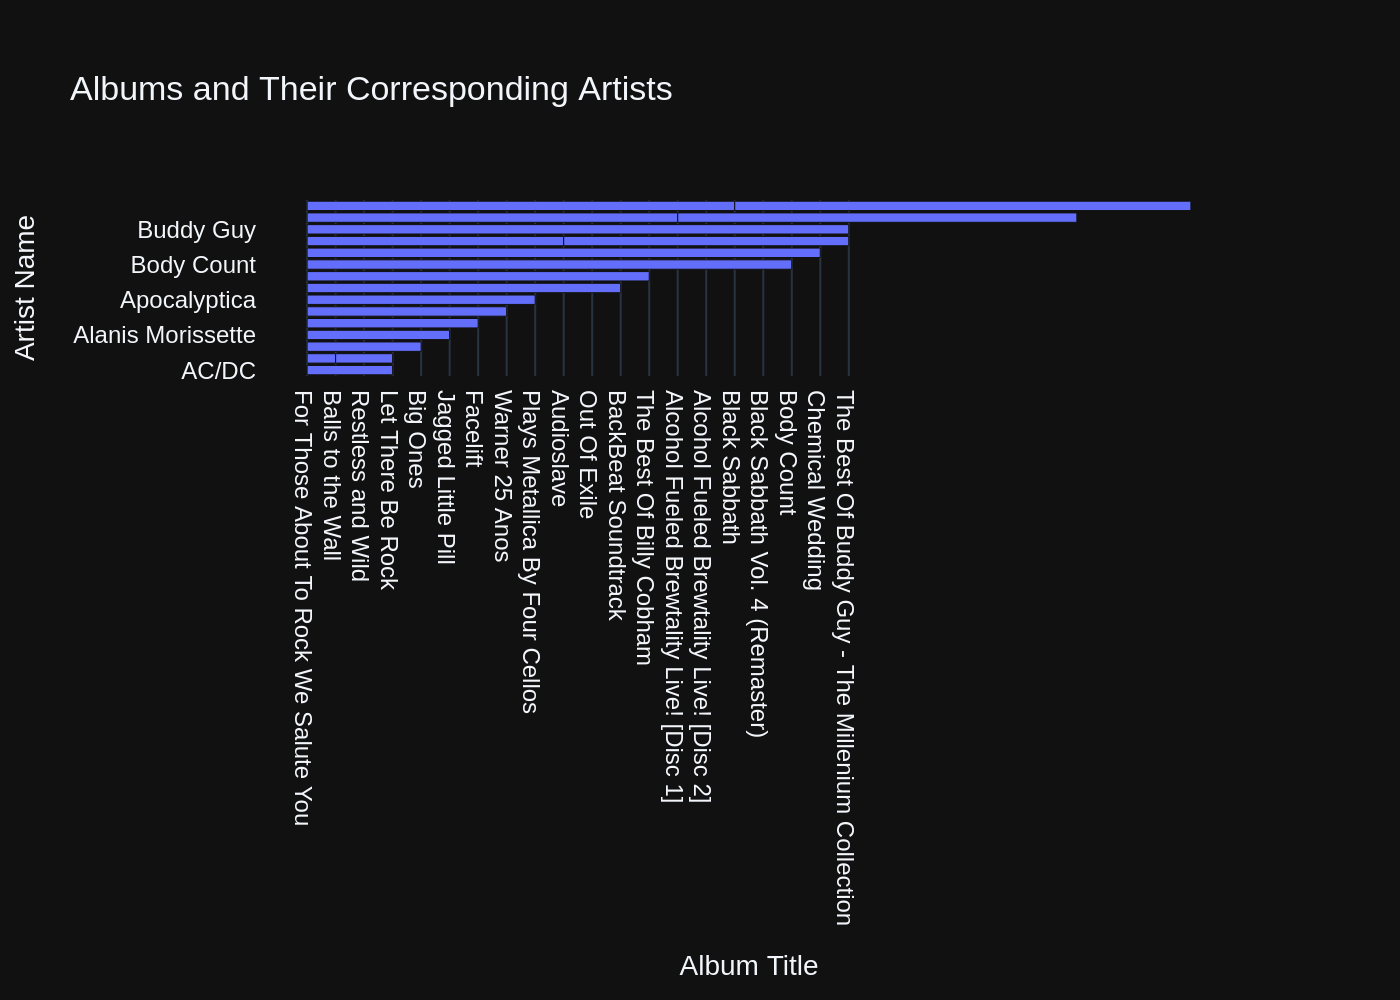





# QUESTION  - 7:  Find all tracks with a name containing "What" (case-insensitive) 


Using model gpt-4o for 933.0 tokens (approx)

[( EXTRACTED SQL )]
SELECT * FROM tracks WHERE Name LIKE '%What%' COLLATE NOCASE;


[( <SQL> )]
generated SQL statement



SELECT * FROM tracks WHERE Name LIKE '%What%' COLLATE NOCASE;


[( <DataFrame> )]
queried dataframe



,TrackId,Name,AlbumId,MediaTypeId,GenreId,Composer,Milliseconds,Bytes,UnitPrice
0,26,What It Takes,5,1,1,"Steven Tyler, Joe Perry, Desmond Child",310622,10144730,0.99
1,88,What You Are,10,1,1,Audioslave/Chris Cornell,249391,5988186,0.99
2,130,Do what cha wanna,13,1,2,George Duke,274155,9018565,0.99
3,342,What is and Should Never Be,30,1,1,Jimmy Page/Robert Plant,260675,8497116,0.99
4,607,So What,48,1,2,Miles Davis,564009,18360449,0.99
5,960,What A Day,76,1,1,"Mike Bordin, Billy Gould, Mike Patton",158275,5203430,0.99
6,1000,What If I Do?,80,1,1,"Dave Grohl, Taylor Hawkins, Nate Mendel, Chris...",302994,9929799,0.99
7,1039,What Now My Love,83,1,12,carl sigman/gilbert becaud/pierre leroyer,149995,4913383,0.99
8,1145,Whatsername,89,1,4,Green Day,252316,8244843,0.99
9,1440,"Whatever It Is, I Just Can't Stop",116,1,1,"Jay Kay/Kay, Jay",247222,8249453,0.99


Using model gpt-4o for 227.5 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.express as px
import plotly.graph_objects as go

if len(df) == 1:
    fig = go.Figure(go.Indicator(
        mode = "number",
        value = df['TrackId'].iloc[0],
        title = {"text": df['Name'].iloc[0]}
    ))
else:
    fig = px.bar(df, x='Name', y='Milliseconds', 
                 hover_data=['AlbumId', 'MediaTypeId', 'GenreId', 'Composer', 'Bytes', 'UnitPrice'],
                 labels={'Milliseconds':'Duration (ms)'},
                 title='Tracks with "What" in the Name')
    fig.update_layout(xaxis_title='Track Name', yaxis_title='Duration (Milliseconds)')

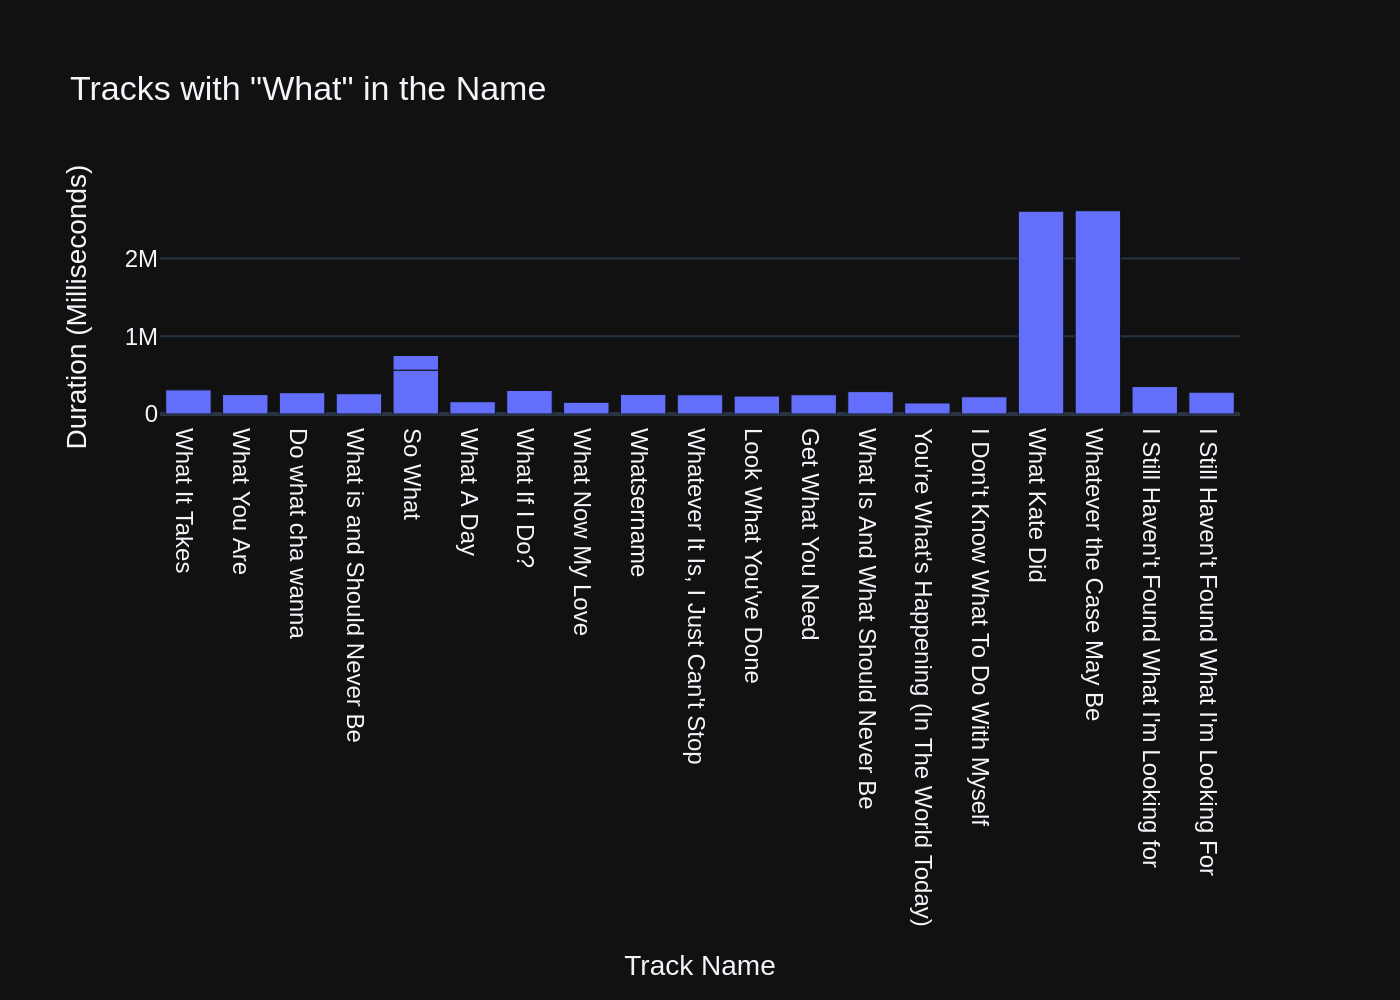





# QUESTION  - 8:  Get the total number of invoices for each customer


Using model gpt-4o for 1317.5 tokens (approx)

[( EXTRACTED SQL )]
SELECT CustomerId, COUNT(*) AS TotalInvoices
FROM invoices
GROUP BY CustomerId;


[( <SQL> )]
generated SQL statement



SELECT CustomerId, COUNT(*) AS TotalInvoices
FROM invoices
GROUP BY CustomerId;


[( <DataFrame> )]
queried dataframe



,CustomerId,TotalInvoices
0,1,7
1,2,7
2,3,7
3,4,7
4,5,7
5,6,7
6,7,7
7,8,7
8,9,7
9,10,7


Using model gpt-4o for 185.75 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.express as px
import plotly.graph_objects as go

if len(df) == 1:
    fig = go.Figure(go.Indicator(
        mode = "number",
        value = df['TotalInvoices'].iloc[0],
        title = {"text": f"Total Invoices for Customer {df['CustomerId'].iloc[0]}"}
    ))
else:
    fig = px.bar(df, x='CustomerId', y='TotalInvoices', title='Total Number of Invoices for Each Customer')

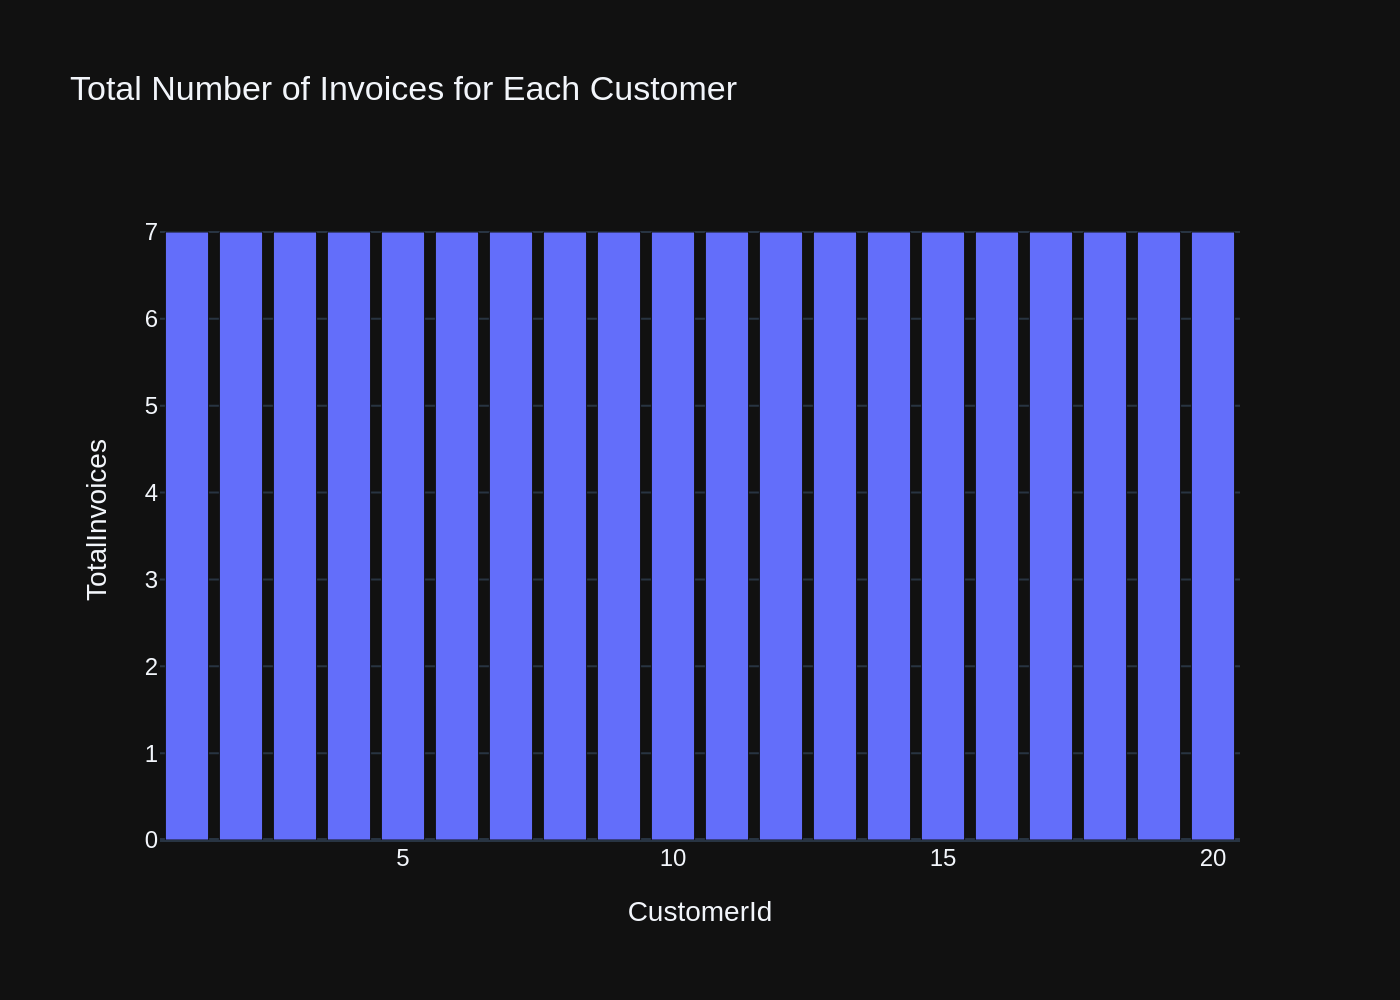





# QUESTION  - 9:  Find the total number of invoices per country


Using model gpt-4o for 1398.0 tokens (approx)

[( EXTRACTED SQL )]
SELECT c.Country, COUNT(i.InvoiceId) AS TotalInvoices
FROM invoices i
JOIN customers c ON i.CustomerId = c.CustomerId
GROUP BY c.Country;


[( <SQL> )]
generated SQL statement



SELECT c.Country, COUNT(i.InvoiceId) AS TotalInvoices
FROM invoices i
JOIN customers c ON i.CustomerId = c.CustomerId
GROUP BY c.Country;


[( <DataFrame> )]
queried dataframe



,Country,TotalInvoices
0,Argentina,7
1,Australia,7
2,Austria,7
3,Belgium,7
4,Brazil,35
5,Canada,56
6,Chile,7
7,Czech Republic,14
8,Denmark,7
9,Finland,7


Using model gpt-4o for 199.5 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.express as px
import plotly.graph_objects as go

if len(df) == 1:
    fig = go.Figure(go.Indicator(
        mode = "number",
        value = df['TotalInvoices'].iloc[0],
        title = {"text": f"Total Invoices for {df['Country'].iloc[0]}"}
    ))
else:
    fig = px.bar(df, x='Country', y='TotalInvoices', title='Total Number of Invoices per Country')

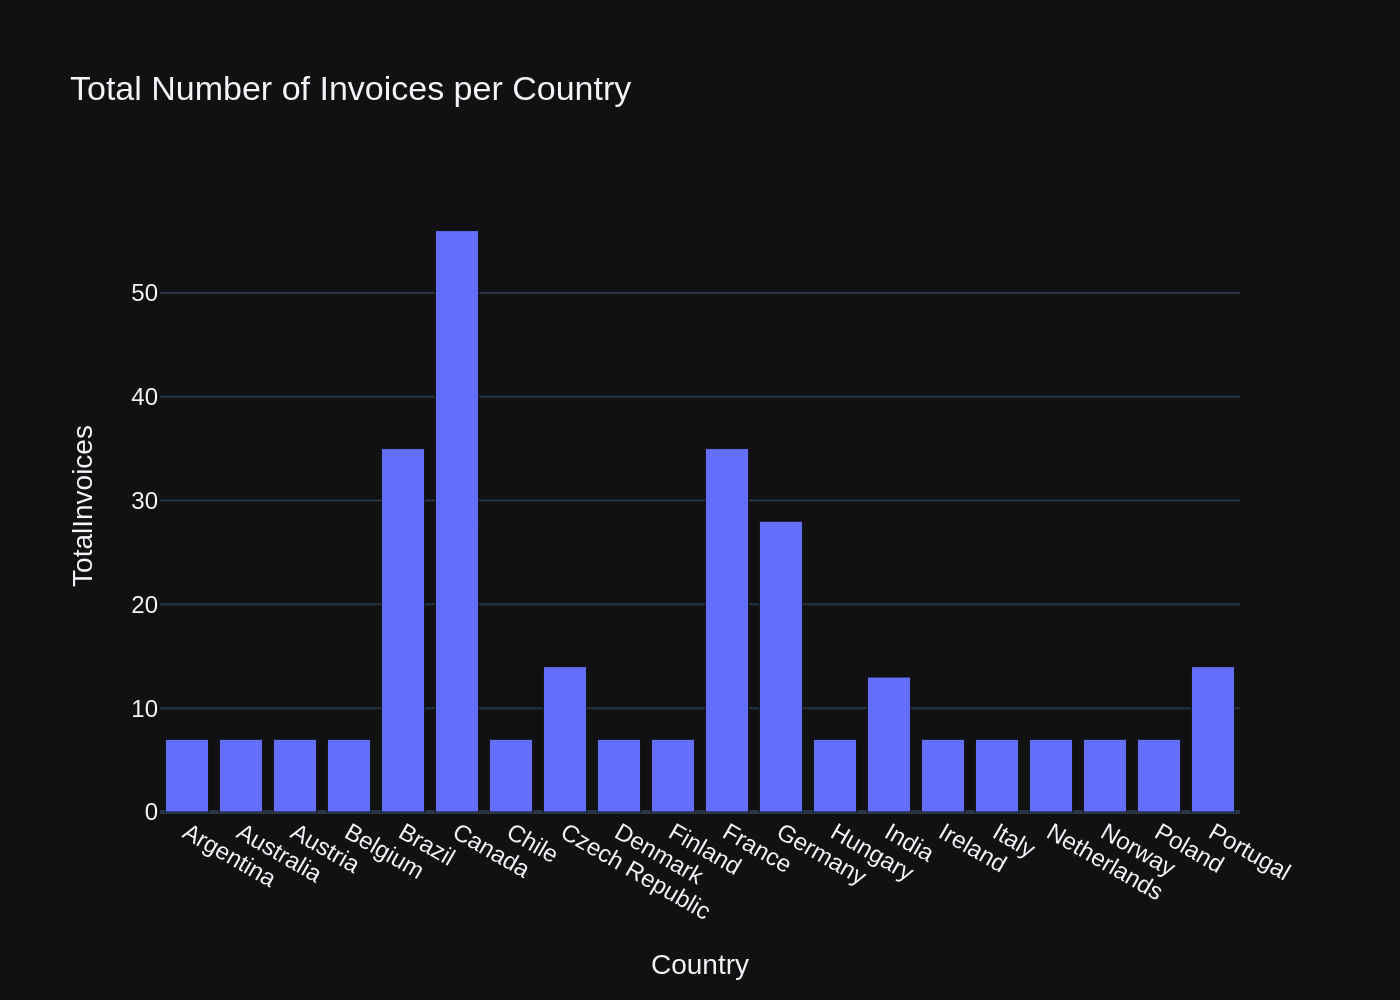





# QUESTION  - 10:  List all invoices with a total exceeding $10


Using model gpt-4o for 1397.75 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT * FROM invoices WHERE Total > 10 LIMIT 20


[( <DataFrame> )]
queried dataframe



,InvoiceId,CustomerId,InvoiceDate,BillingAddress,BillingCity,BillingState,BillingCountry,BillingPostalCode,Total
0,5,23,2009-01-11 00:00:00,69 Salem Street,Boston,MA,USA,2113,13.86
1,12,2,2009-02-11 00:00:00,Theodor-Heuss-Straße 34,Stuttgart,None,Germany,70174,13.86
2,19,40,2009-03-14 00:00:00,"8, Rue Hanovre",Paris,None,France,75002,13.86
3,26,19,2009-04-14 00:00:00,1 Infinite Loop,Cupertino,CA,USA,95014,13.86
4,33,57,2009-05-15 00:00:00,"Calle Lira, 198",Santiago,None,Chile,None,13.86
5,40,36,2009-06-15 00:00:00,Tauentzienstraße 8,Berlin,None,Germany,10789,13.86
6,47,15,2009-07-16 00:00:00,700 W Pender Street,Vancouver,BC,Canada,V6C 1G8,13.86
7,54,53,2009-08-16 00:00:00,113 Lupus St,London,None,United Kingdom,SW1V 3EN,13.86
8,61,32,2009-09-16 00:00:00,696 Osborne Street,Winnipeg,MB,Canada,R3L 2B9,13.86
9,68,11,2009-10-17 00:00:00,"Av. Paulista, 2022",São Paulo,SP,Brazil,01310-200,13.86


Using model gpt-4o for 228.25 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.express as px
import plotly.graph_objects as go

if len(df) == 1:
    fig = go.Figure(go.Indicator(
        mode = "number",
        value = df['Total'].iloc[0],
        title = {"text": "Total of Single Invoice"}
    ))
else:
    fig = px.bar(df, x='InvoiceId', y='Total', title='Invoices with Total Exceeding $10')

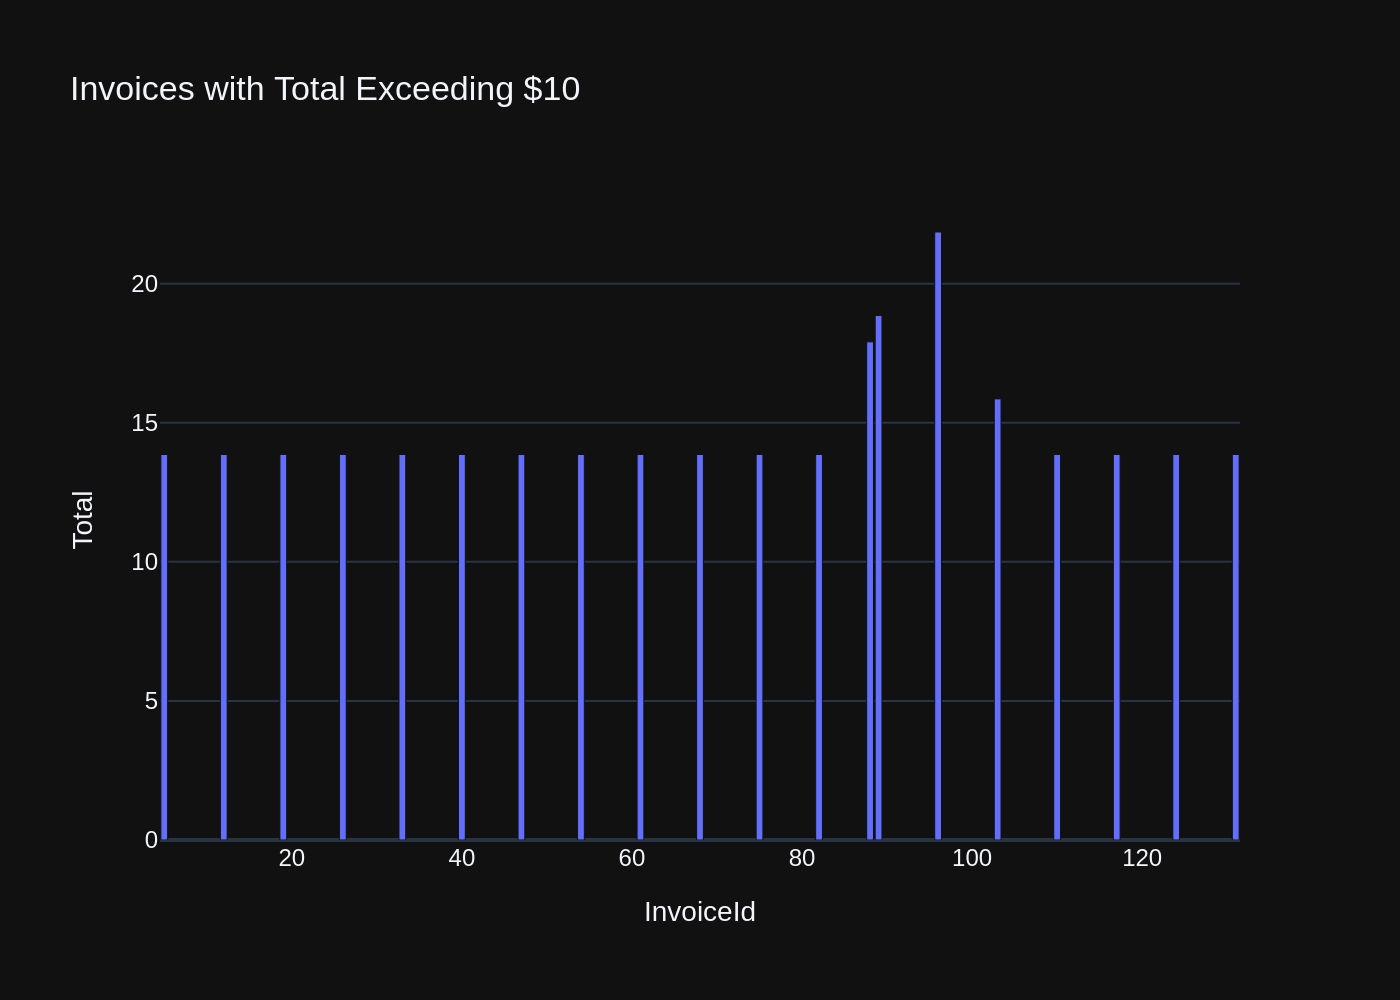





# QUESTION  - 11:  Find all invoices since 2010 and the total amount invoiced:


Using model gpt-4o for 1552.5 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT COUNT(*) AS NumberOfInvoices, SUM(Total) AS TotalAmountInvoiced
FROM invoices
WHERE InvoiceDate >= '2010-01-01' LIMIT 20


[( <DataFrame> )]
queried dataframe



,NumberOfInvoices,TotalAmountInvoiced
0,329,1879.14


Using model gpt-4o for 202.0 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Indicator(
    mode = "number",
    value = df['TotalAmountInvoiced'].iloc[0],
    title = {"text": "Total Amount Invoiced Since 2010"},
    number = {'prefix': "$"}
))

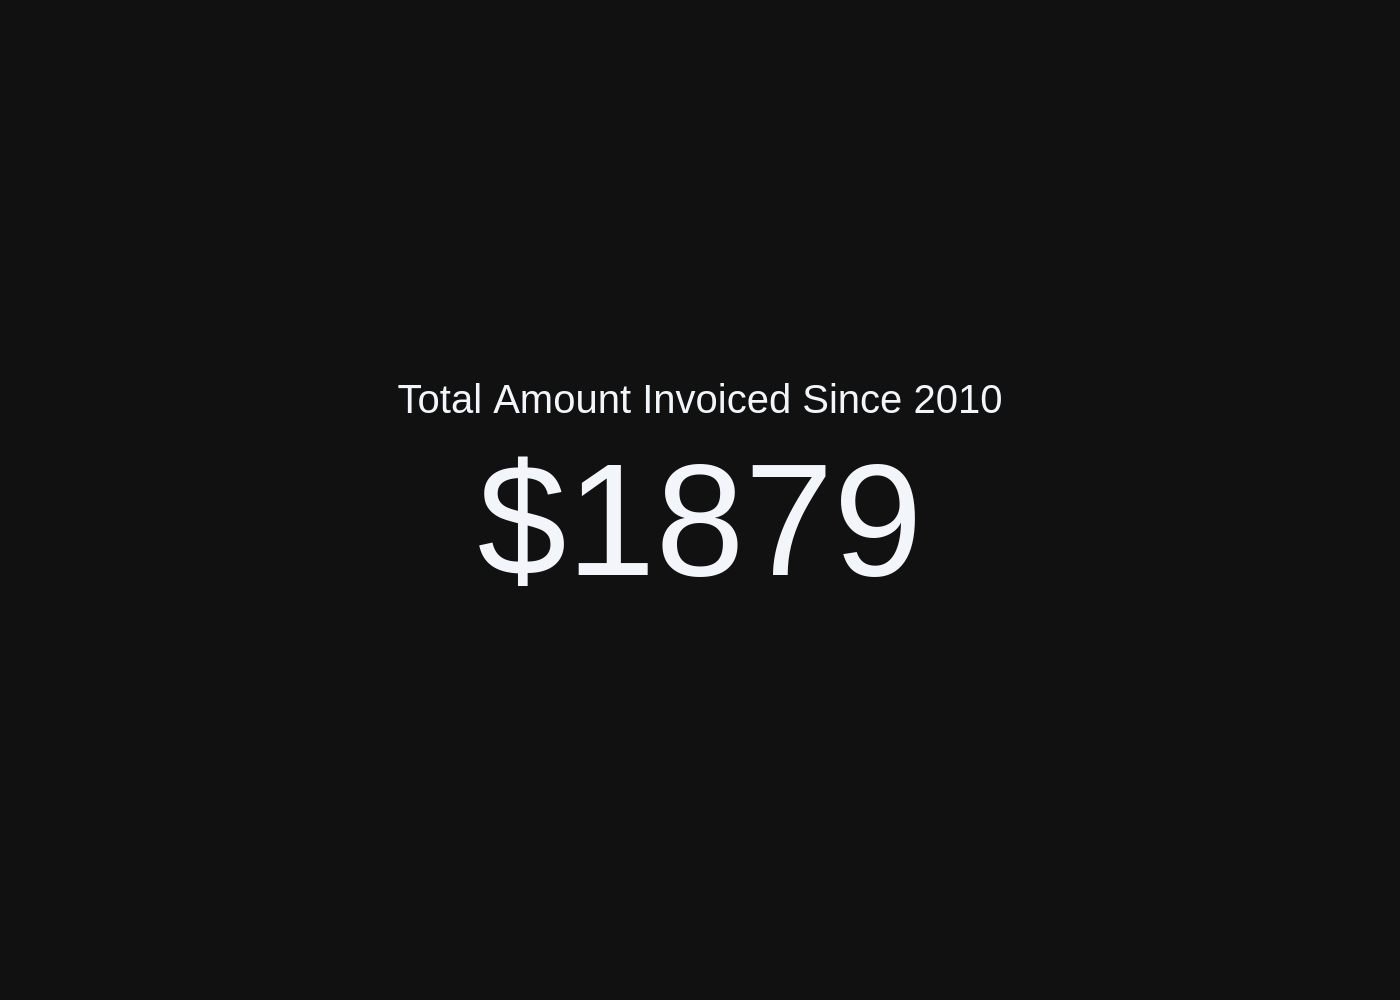





# QUESTION  - 12:  List all employees and their reporting manager's name (if any):


Using model gpt-4o for 1525.25 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT e.EmployeeId, e.FirstName || ' ' || e.LastName AS EmployeeName, 
       m.FirstName || ' ' || m.LastName AS ManagerName
FROM employees e
LEFT JOIN employees m ON e.ReportsTo = m.EmployeeId LIMIT 20


[( <DataFrame> )]
queried dataframe



,EmployeeId,EmployeeName,ManagerName
0,1,Andrew Adams,None
1,2,Nancy Edwards,Andrew Adams
2,3,Jane Peacock,Nancy Edwards
3,4,Margaret Park,Nancy Edwards
4,5,Steve Johnson,Nancy Edwards
5,6,Michael Mitchell,Andrew Adams
6,7,Robert King,Michael Mitchell
7,8,Laura Callahan,Michael Mitchell


Using model gpt-4o for 224.0 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.express as px
import plotly.graph_objects as go

if len(df) == 1:
    fig = go.Figure(go.Indicator(
        mode = "number",
        value = df['EmployeeId'].iloc[0],
        title = {"text": f"Employee: {df['EmployeeName'].iloc[0]}<br>Manager: {df['ManagerName'].iloc[0]}"}
    ))
else:
    fig = px.bar(df, x='EmployeeName', y='EmployeeId', color='ManagerName',
                 labels={'EmployeeId': 'Employee ID', 'EmployeeName': 'Employee Name', 'ManagerName': 'Manager Name'},
                 title='Employees and Their Reporting Managers')
    fig.update_layout(xaxis_title='Employee Name', yaxis_title='Employee ID')

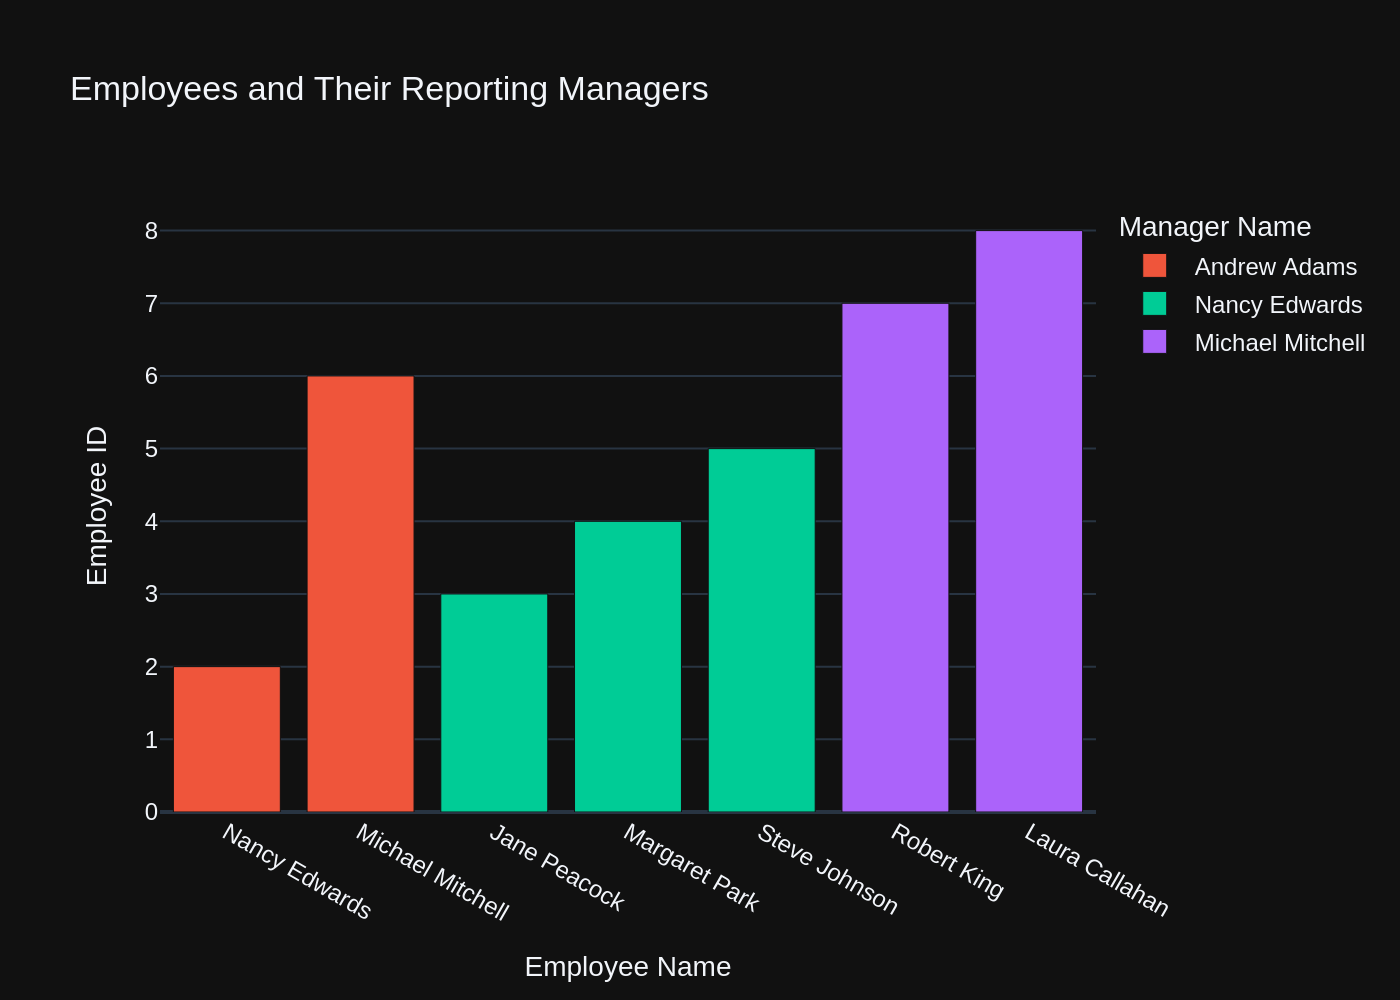





# QUESTION  - 13:   Get the average invoice total for each customer:


Using model gpt-4o for 1356.0 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT CustomerId, AVG(Total) AS AverageInvoiceTotal
FROM invoices
GROUP BY CustomerId LIMIT 20


[( <DataFrame> )]
queried dataframe



,CustomerId,AverageInvoiceTotal
0,1,5.660000
1,2,5.374286
2,3,5.660000
3,4,5.660000
4,5,5.802857
5,6,7.088571
6,7,6.088571
7,8,5.374286
8,9,5.374286
9,10,5.374286


Using model gpt-4o for 191.5 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.express as px
import plotly.graph_objects as go

if len(df) == 1:
    fig = go.Figure(go.Indicator(
        mode = "number",
        value = df['AverageInvoiceTotal'].iloc[0],
        title = {"text": "Average Invoice Total"}
    ))
else:
    fig = px.bar(df, x='CustomerId', y='AverageInvoiceTotal', 
                 title='Average Invoice Total for Each Customer',
                 labels={'CustomerId': 'Customer ID', 'AverageInvoiceTotal': 'Average Invoice Total'})

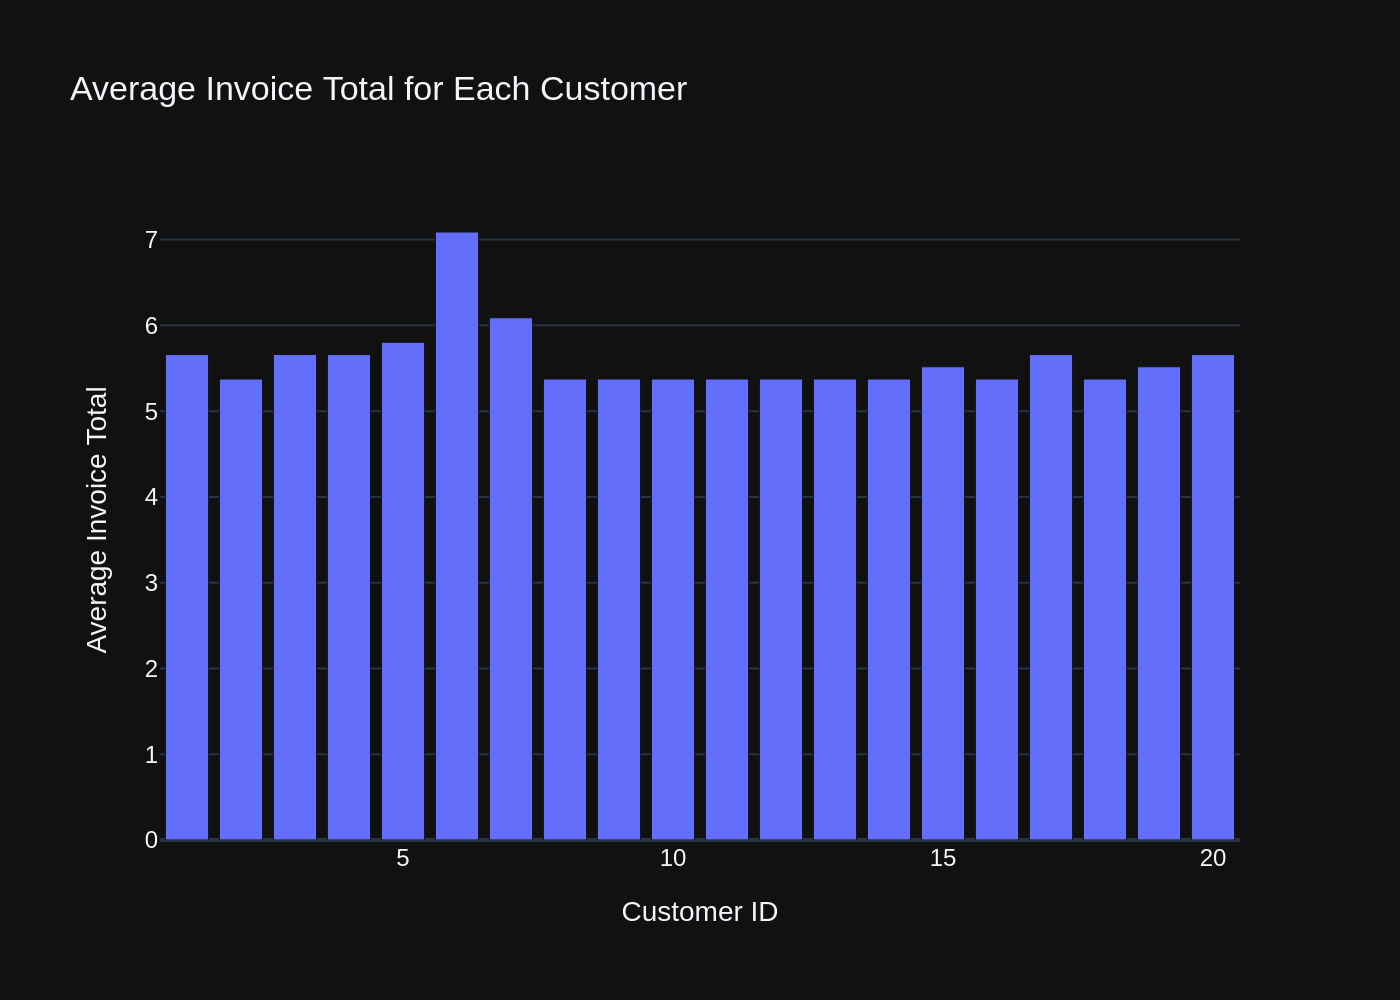





# QUESTION  - 14:  Find the top 5 most expensive tracks (based on unit price):


Using model gpt-4o for 1161.5 tokens (approx)

[( EXTRACTED SQL )]
SELECT * FROM tracks
ORDER BY UnitPrice DESC
LIMIT 5;


[( <SQL> )]
generated SQL statement



SELECT * FROM tracks
ORDER BY UnitPrice DESC
LIMIT 5;


[( <DataFrame> )]
queried dataframe



,TrackId,Name,AlbumId,MediaTypeId,GenreId,Composer,Milliseconds,Bytes,UnitPrice
0,2819,Battlestar Galactica: The Story So Far,226,3,18,None,2622250,490750393,1.99
1,2820,Occupation / Precipice,227,3,19,None,5286953,1054423946,1.99
2,2821,"Exodus, Pt. 1",227,3,19,None,2621708,475079441,1.99
3,2822,"Exodus, Pt. 2",227,3,19,None,2618000,466820021,1.99
4,2823,Collaborators,227,3,19,None,2626626,483484911,1.99


Using model gpt-4o for 222.0 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.express as px
import plotly.graph_objects as go

if len(df) == 1:
    fig = go.Figure(go.Indicator(
        mode = "number",
        value = df['UnitPrice'].iloc[0],
        title = {"text": "Most Expensive Track Price"}
    ))
else:
    fig = px.bar(df, x='Name', y='UnitPrice', title='Top 5 Most Expensive Tracks')
    fig.update_layout(xaxis_title='Track Name', yaxis_title='Unit Price')

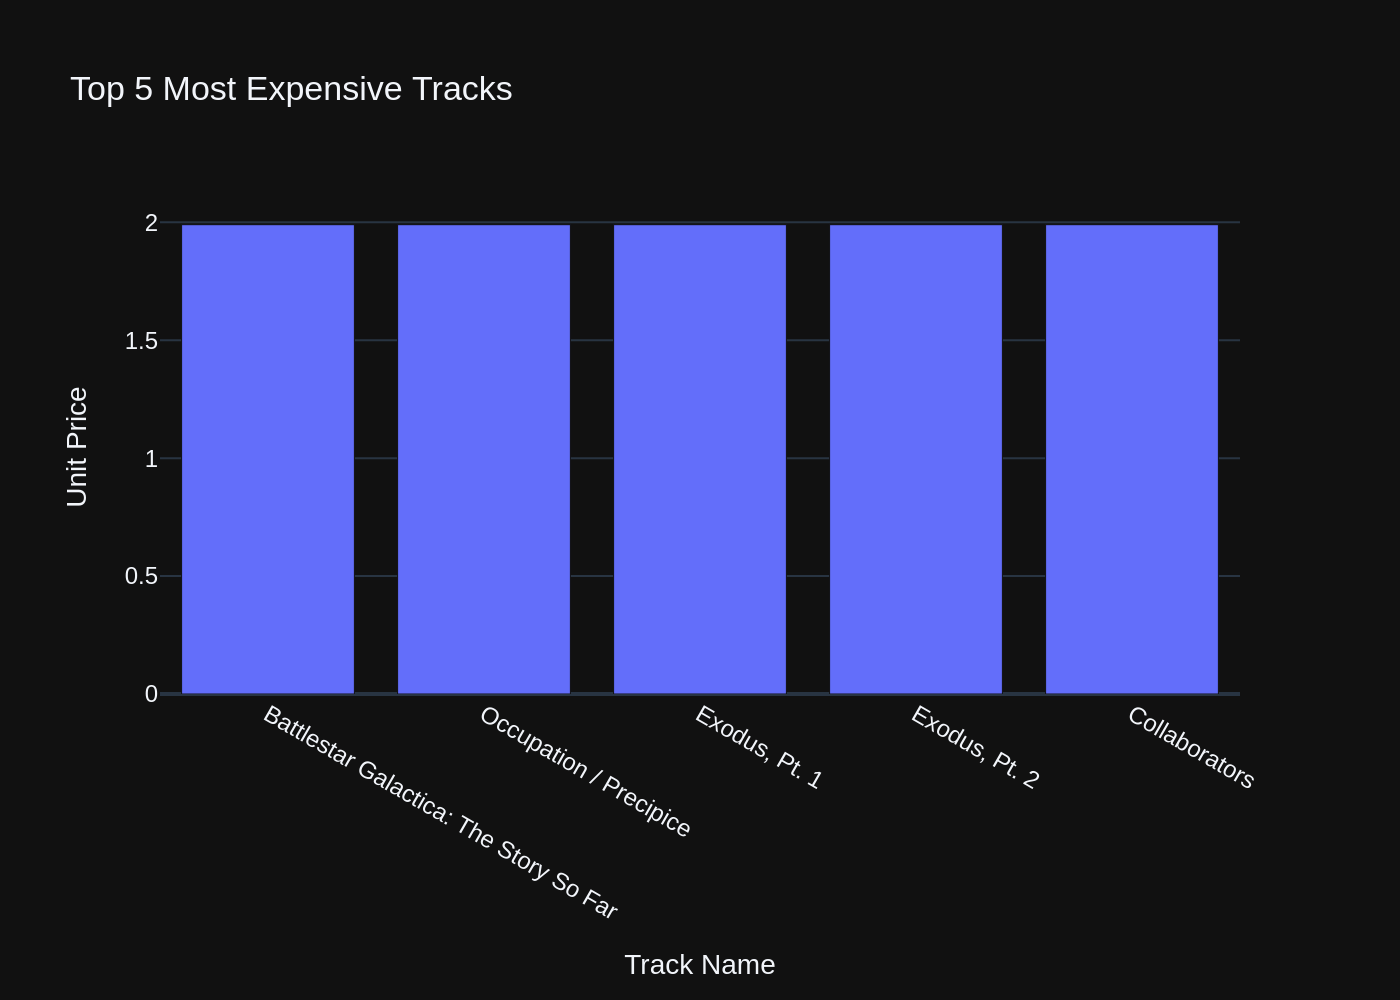





# QUESTION  - 15:  List all genres and the number of tracks in each genre:


Using model gpt-4o for 1080.75 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT g.Name AS GenreName, COUNT(t.TrackId) AS NumberOfTracks
FROM genres g
LEFT JOIN tracks t ON g.GenreId = t.GenreId
GROUP BY g.GenreId LIMIT 20


[( <DataFrame> )]
queried dataframe



,GenreName,NumberOfTracks
0,Rock,1297
1,Jazz,130
2,Metal,374
3,Alternative & Punk,332
4,Rock And Roll,12
5,Blues,81
6,Latin,579
7,Reggae,58
8,Pop,48
9,Soundtrack,43


Using model gpt-4o for 203.25 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.express as px
import plotly.graph_objects as go

if len(df) == 1:
    fig = go.Figure(go.Indicator(
        mode = "number",
        value = df['NumberOfTracks'].iloc[0],
        title = {"text": df['GenreName'].iloc[0]}
    ))
else:
    fig = px.bar(df, x='GenreName', y='NumberOfTracks', title='Number of Tracks per Genre')

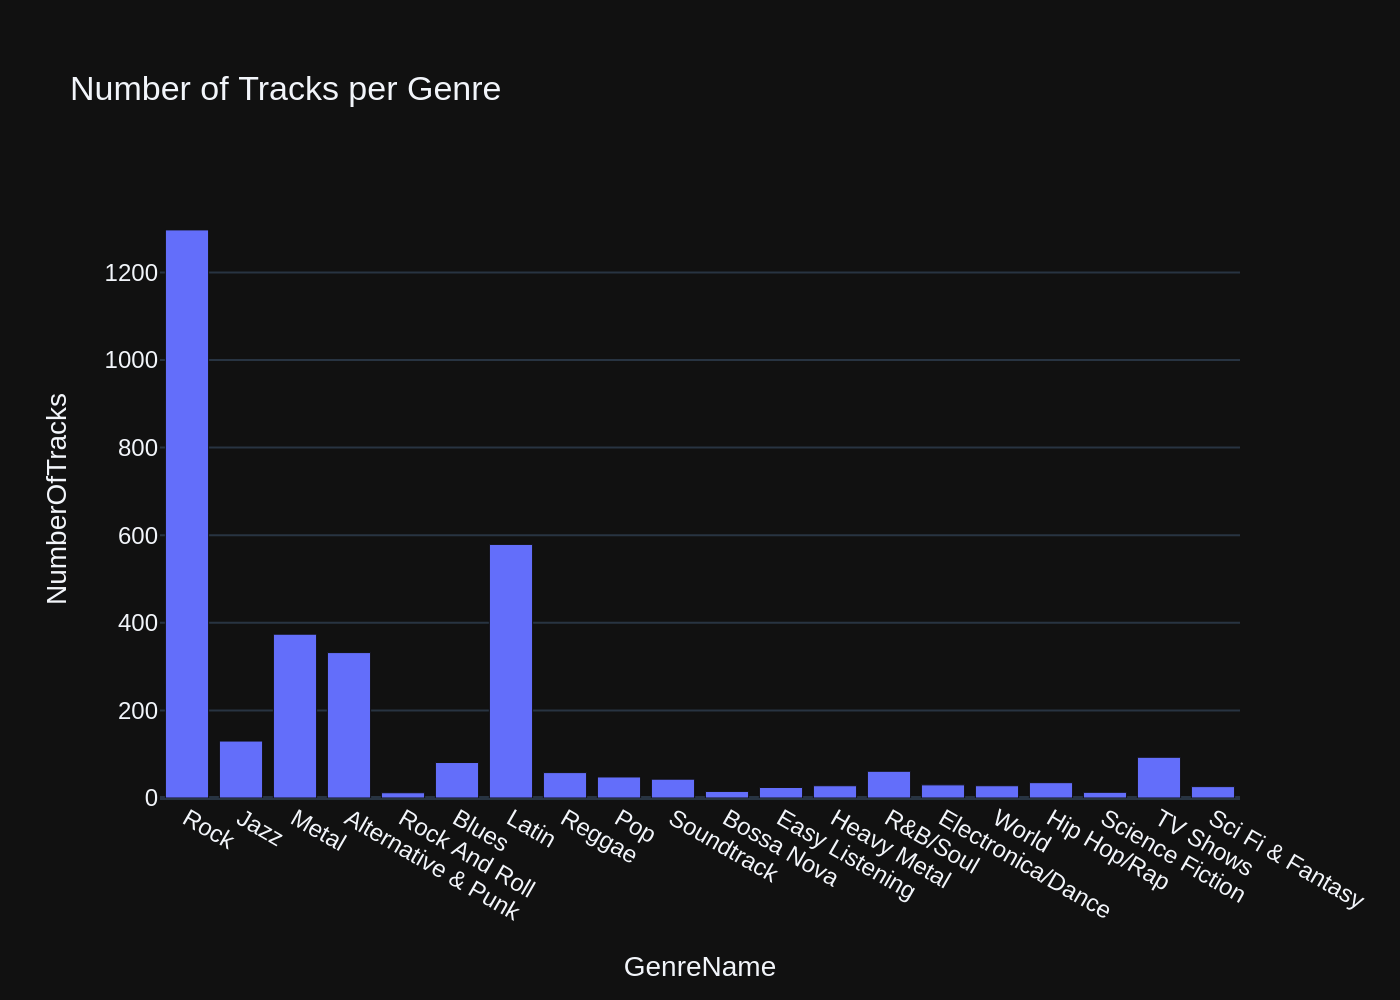





# QUESTION  - 16:  Get all genres that do not have any tracks associated with them:


Using model gpt-4o for 1118.75 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT g.Name AS GenreName
FROM genres g
LEFT JOIN tracks t ON g.GenreId = t.GenreId
WHERE t.TrackId IS NULL LIMIT 20


[( <DataFrame> )]
queried dataframe



,GenreName



[( RETRY )]
***** 1 *****

Using model gpt-4o for 1298.0 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT g.Name AS GenreName
FROM genres g
LEFT JOIN tracks t ON g.GenreId = t.GenreId
WHERE t.TrackId IS NULL LIMIT 20


[( <DataFrame> )]
queried dataframe



,GenreName



[( RETRY )]
***** 2 *****

Using model gpt-4o for 1345.5 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT g.Name AS GenreName
FROM genres g
LEFT JOIN tracks t ON g.GenreId = t.GenreId
WHERE t.TrackId IS NULL LIMIT 20


[( <DataFrame> )]
queried dataframe



,GenreName



[( RETRY )]
***** 3 *****

Using model gpt-4o for 1405.25 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT g.Name AS GenreName
FROM genres g
LEFT JOIN tracks t ON g.GenreId = t.GenreId
WHERE t.TrackId IS NULL LIMIT 20


[( <DataFrame> )]
queried dataframe



,GenreName






# QUESTION  - 17:  List all customers who have not placed any orders:


Using model gpt-4o for 1650.0 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT c.CustomerId, c.FirstName, c.LastName
FROM customers c
LEFT JOIN invoices i ON c.CustomerId = i.CustomerId
WHERE i.InvoiceId IS NULL LIMIT 20


[( <DataFrame> )]
queried dataframe



,CustomerId,FirstName,LastName



[( RETRY )]
***** 1 *****

Using model gpt-4o for 1518.75 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT c.*
FROM customers c
LEFT JOIN invoices i ON c.CustomerId = i.CustomerId
WHERE i.InvoiceId IS NULL LIMIT 20


[( <DataFrame> )]
queried dataframe



,CustomerId,FirstName,LastName,Company,Address,City,State,Country,PostalCode,Phone,Fax,Email,SupportRepId



[( RETRY )]
***** 2 *****

Using model gpt-4o for 1559.0 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT * 
FROM customers 
WHERE CustomerId NOT IN (SELECT CustomerId FROM invoices) LIMIT 20


[( <DataFrame> )]
queried dataframe



,CustomerId,FirstName,LastName,Company,Address,City,State,Country,PostalCode,Phone,Fax,Email,SupportRepId



[( RETRY )]
***** 3 *****

Using model gpt-4o for 1624.0 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT c.CustomerId, c.FirstName, c.LastName
FROM customers c
LEFT JOIN invoices i ON c.CustomerId = i.CustomerId
WHERE i.InvoiceId IS NULL LIMIT 20


[( <DataFrame> )]
queried dataframe



,CustomerId,FirstName,LastName






# QUESTION  - 18:   
        Can you find the top 10 most popular artists based on the number of tracks?
        Hint: There are 3 tables - artists, albums and tracks, 
        where albums and artists are linked by ArtistId, albums and tracks are linked by AlbumId,
    


Using model gpt-4o for 1147.0 tokens (approx)

[( EXTRACTED SQL )]
SELECT ar.Name AS ArtistName, COUNT(t.TrackId) AS NumberOfTracks
FROM artists ar
JOIN albums al ON ar.ArtistId = al.ArtistId
JOIN tracks t ON al.AlbumId = t.AlbumId
GROUP BY ar.ArtistId
ORDER BY NumberOfTracks DESC
LIMIT 10;


[( <SQL> )]
generated SQL statement



SELECT ar.Name AS ArtistName, COUNT(t.TrackId) AS NumberOfTracks
FROM artists ar
JOIN albums al ON ar.ArtistId = al.ArtistId
JOIN tracks t ON al.AlbumId = t.AlbumId
GROUP BY ar.ArtistId
ORDER BY NumberOfTracks DESC
LIMIT 10;


[( <DataFrame> )]
queried dataframe



,ArtistName,NumberOfTracks
0,Iron Maiden,213
1,U2,135
2,Led Zeppelin,114
3,Metallica,112
4,Deep Purple,92
5,Lost,92
6,Pearl Jam,67
7,Lenny Kravitz,57
8,Various Artists,56
9,The Office,53


Using model gpt-4o for 271.5 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.express as px
import plotly.graph_objects as go

if len(df) == 1:
    fig = go.Figure(go.Indicator(
        mode = "number",
        value = df['NumberOfTracks'].iloc[0],
        title = {"text": df['ArtistName'].iloc[0]}
    ))
else:
    fig = px.bar(df, x='ArtistName', y='NumberOfTracks', title='Top 10 Most Popular Artists by Number of Tracks')
    fig.update_layout(xaxis_title='Artist Name', yaxis_title='Number of Tracks')

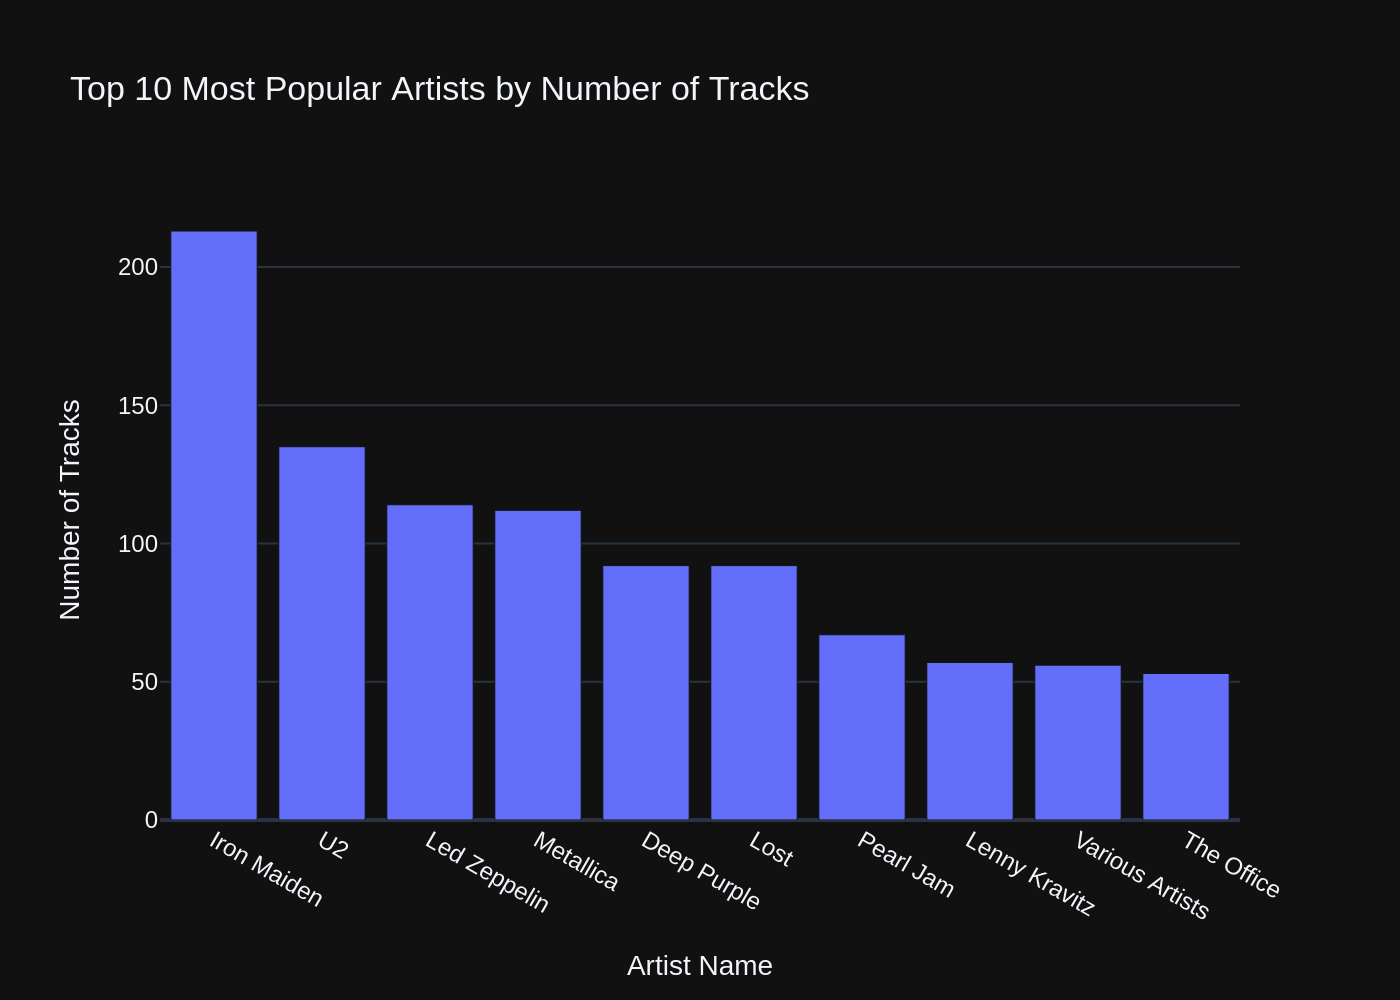





# QUESTION  - 19:  List all customers from Canada and their email addresses:


Using model gpt-4o for 1468.75 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT FirstName, LastName, Email
FROM customers
WHERE Country = 'Canada' LIMIT 20


[( <DataFrame> )]
queried dataframe



,FirstName,LastName,Email
0,François,Tremblay,ftremblay@gmail.com
1,Mark,Philips,mphilips12@shaw.ca
2,Jennifer,Peterson,jenniferp@rogers.ca
3,Robert,Brown,robbrown@shaw.ca
4,Edward,Francis,edfrancis@yachoo.ca
5,Martha,Silk,marthasilk@gmail.com
6,Aaron,Mitchell,aaronmitchell@yahoo.ca
7,Ellie,Sullivan,ellie.sullivan@shaw.ca


Using model gpt-4o for 189.75 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.express as px
import plotly.graph_objects as go

if len(df) == 1:
    fig = go.Figure(go.Indicator(
        mode = "number",
        value = 1,
        title = {"text": "Number of Customers from Canada"}
    ))
else:
    fig = px.bar(df, x='FirstName', y='Email', text='LastName', title='Customers from Canada')
    fig.update_traces(textposition='outside')

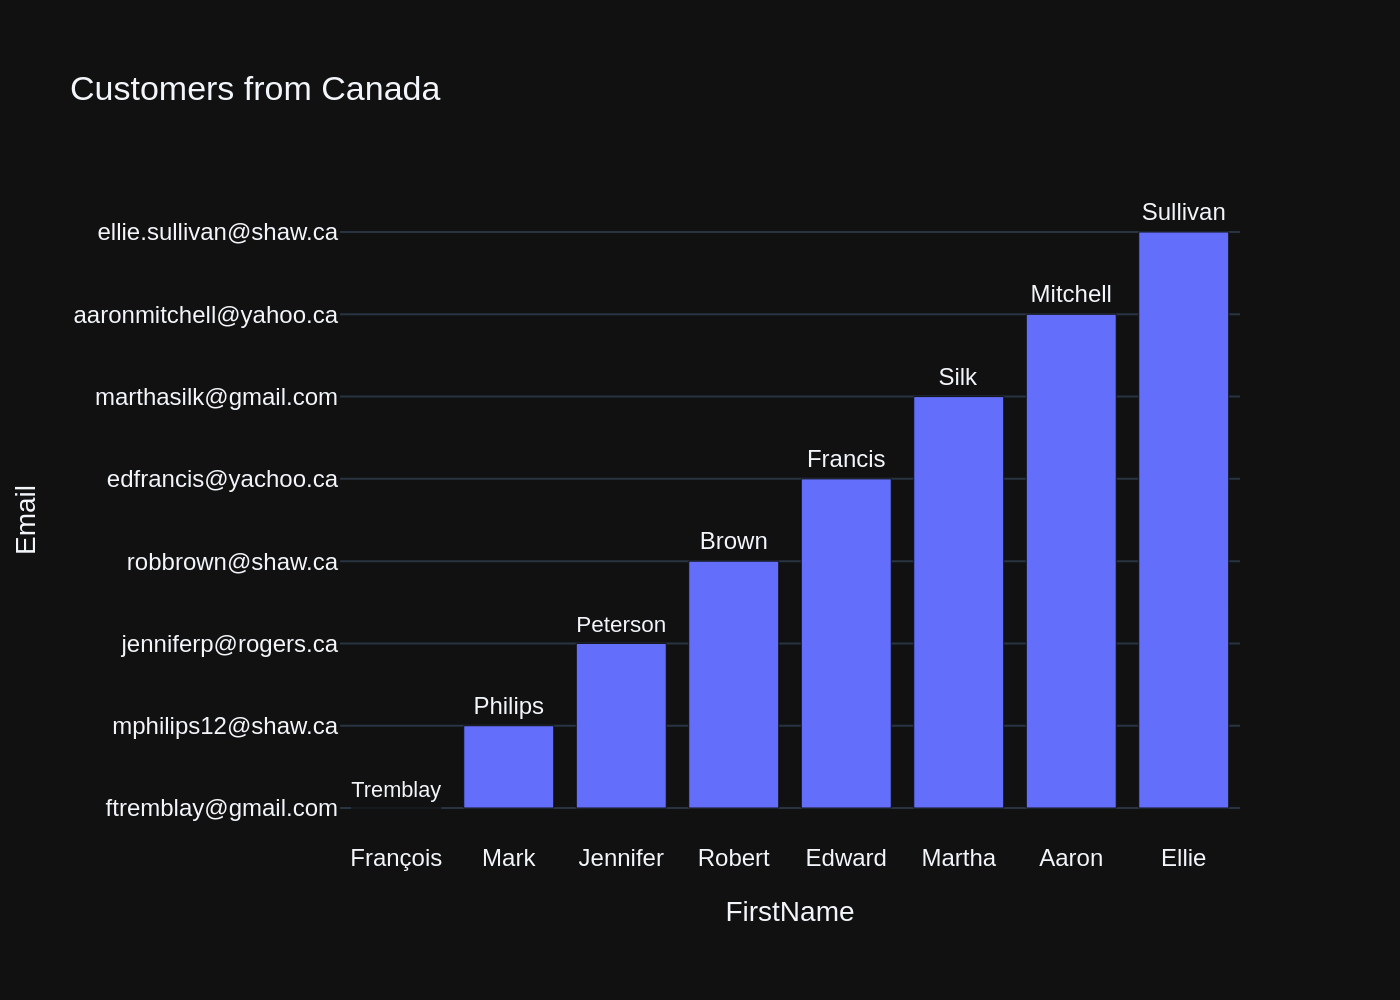





# QUESTION  - 20:  Find the customer with the most invoices 


Using model gpt-4o for 1465.0 tokens (approx)

[( EXTRACTED SQL )]
SELECT CustomerId, COUNT(*) AS TotalInvoices
FROM invoices
GROUP BY CustomerId
ORDER BY TotalInvoices DESC
LIMIT 1;


[( <SQL> )]
generated SQL statement



SELECT CustomerId, COUNT(*) AS TotalInvoices
FROM invoices
GROUP BY CustomerId
ORDER BY TotalInvoices DESC
LIMIT 1;


[( <DataFrame> )]
queried dataframe



,CustomerId,TotalInvoices
0,1,7


Using model gpt-4o for 190.5 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.graph_objects as go

fig = go.Figure(go.Indicator(
    mode = "number",
    value = df['TotalInvoices'].iloc[0],
    title = {"text": f"Customer ID: {df['CustomerId'].iloc[0]}<br>Total Invoices"}
))

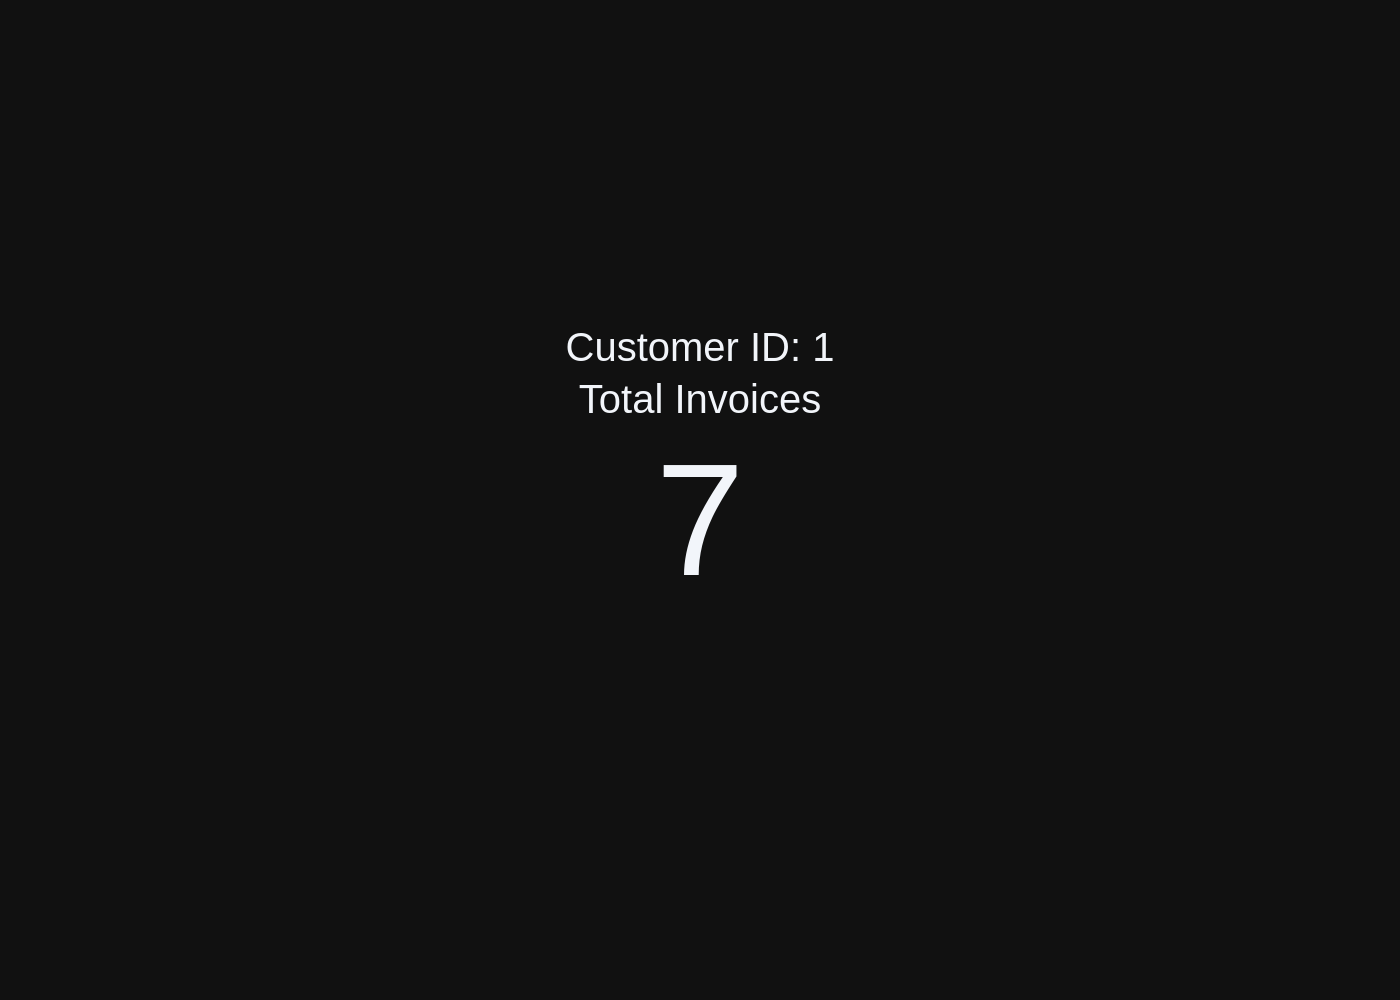





# QUESTION  - 21:  Find the customer who bought the most albums in total quantity (across all invoices):


Using model gpt-4o for 1316.25 tokens (approx)

[( EXTRACTED SQL )]
SELECT i.CustomerId, SUM(ii.Quantity) AS TotalAlbumsBought
FROM invoice_items ii
JOIN invoices i ON ii.InvoiceId = i.InvoiceId
JOIN tracks t ON ii.TrackId = t.TrackId
JOIN albums al ON t.AlbumId = al.AlbumId
GROUP BY i.CustomerId
ORDER BY TotalAlbumsBought DESC
LIMIT 1;


[( <SQL> )]
generated SQL statement



SELECT i.CustomerId, SUM(ii.Quantity) AS TotalAlbumsBought
FROM invoice_items ii
JOIN invoices i ON ii.InvoiceId = i.InvoiceId
JOIN tracks t ON ii.TrackId = t.TrackId
JOIN albums al ON t.AlbumId = al.AlbumId
GROUP BY i.CustomerId
ORDER BY TotalAlbumsBought DESC
LIMIT 1;


[( <DataFrame> )]
queried dataframe



,CustomerId,TotalAlbumsBought
0,1,38


Using model gpt-4o for 242.25 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.graph_objects as go

fig = go.Figure(go.Indicator(
    mode = "number",
    value = df['TotalAlbumsBought'].iloc[0],
    title = {"text": "Total Albums Bought by Top Customer"},
    number = {'valueformat': ','}
))

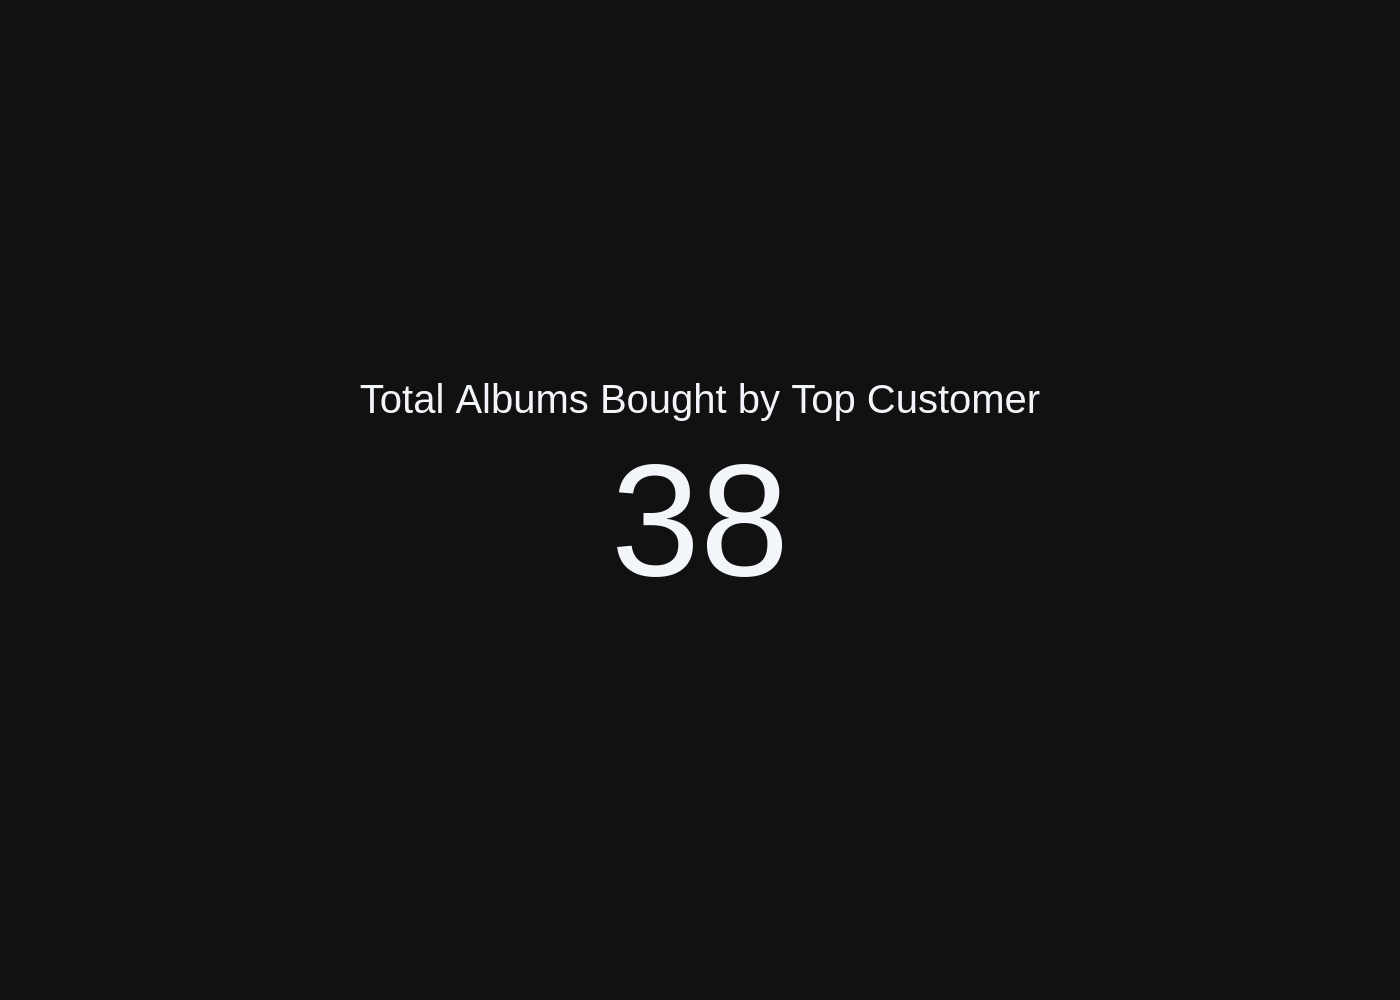





# QUESTION  - 22:        
        Find the top 5 customers who bought the most albums in total quantity (across all invoices):
        Hint: album quantity is found in invoice_items, 
    


Using model gpt-4o for 1375.25 tokens (approx)

[( EXTRACTED SQL )]
SELECT i.CustomerId, SUM(ii.Quantity) AS TotalAlbumsBought
FROM invoice_items ii
JOIN invoices i ON ii.InvoiceId = i.InvoiceId
JOIN tracks t ON ii.TrackId = t.TrackId
JOIN albums al ON t.AlbumId = al.AlbumId
GROUP BY i.CustomerId
ORDER BY TotalAlbumsBought DESC
LIMIT 5;


[( <SQL> )]
generated SQL statement



SELECT i.CustomerId, SUM(ii.Quantity) AS TotalAlbumsBought
FROM invoice_items ii
JOIN invoices i ON ii.InvoiceId = i.InvoiceId
JOIN tracks t ON ii.TrackId = t.TrackId
JOIN albums al ON t.AlbumId = al.AlbumId
GROUP BY i.CustomerId
ORDER BY TotalAlbumsBought DESC
LIMIT 5;


[( <DataFrame> )]
queried dataframe



,CustomerId,TotalAlbumsBought
0,1,38
1,2,38
2,3,38
3,4,38
4,5,38


Using model gpt-4o for 263.25 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.express as px
import plotly.graph_objects as go

if len(df) == 1:
    fig = go.Figure(go.Indicator(
        mode = "number",
        value = df['TotalAlbumsBought'].iloc[0],
        title = {"text": "Total Albums Bought by Top Customer"},
        domain = {'x': [0, 1], 'y': [0, 1]}
    ))
else:
    fig = px.bar(df, x='CustomerId', y='TotalAlbumsBought', 
                 title='Top 5 Customers by Total Albums Bought',
                 labels={'CustomerId': 'Customer ID', 'TotalAlbumsBought': 'Total Albums Bought'})
    fig.update_traces(marker_color='blue')

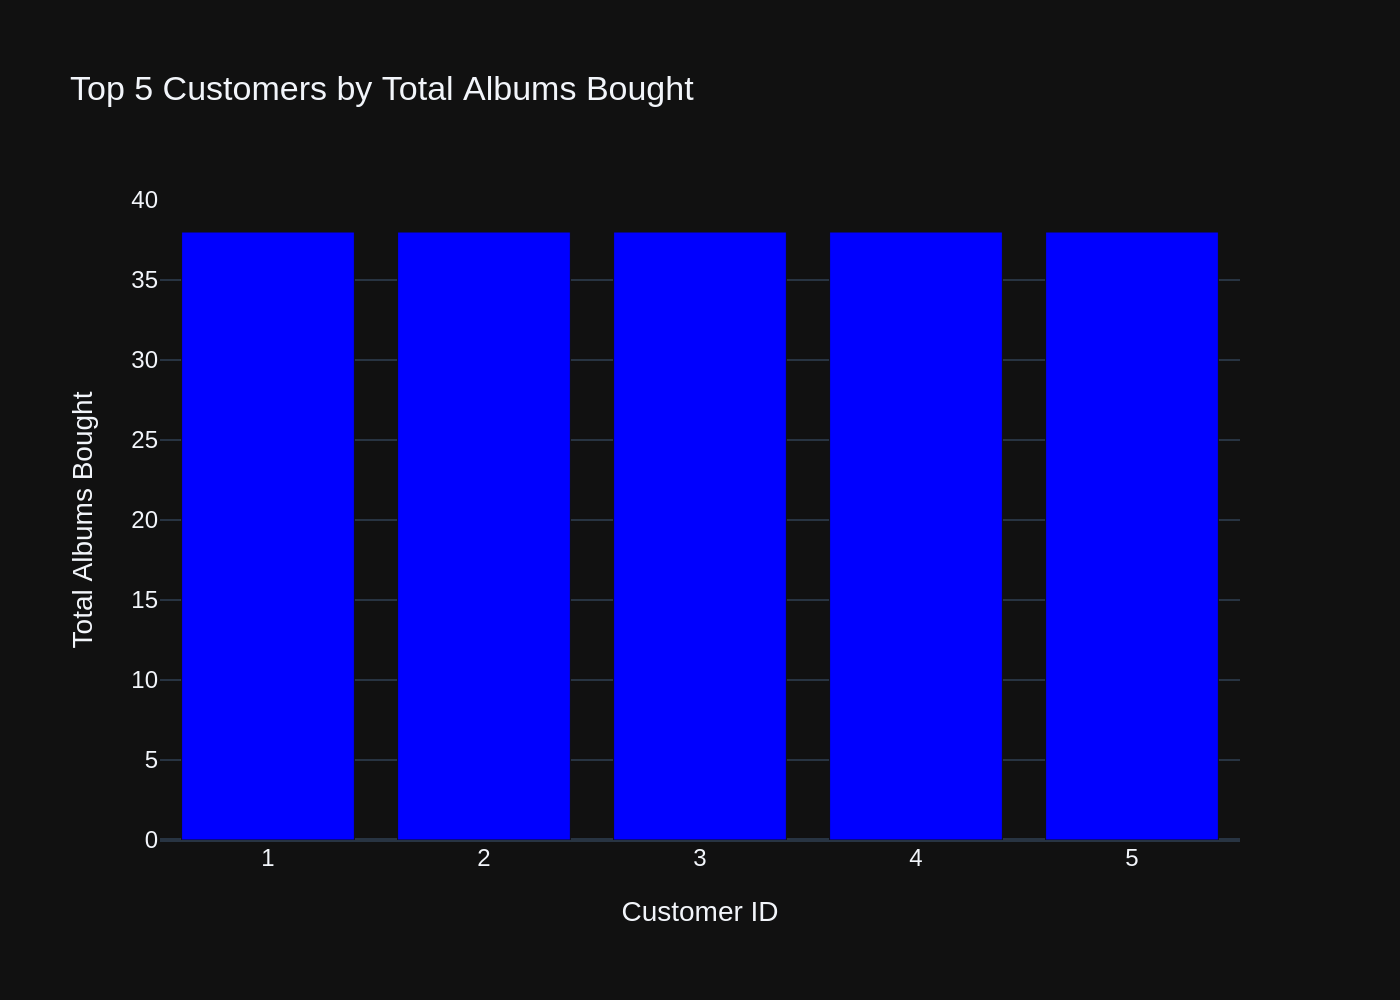





# QUESTION  - 23:    
         Find the top 5 customers who spent the most money overall,  
         Hint: order total can be found on invoices table, calculation using invoice_items detail table is unnecessary 
    


Using model gpt-4o for 1644.75 tokens (approx)

[( EXTRACTED SQL )]
SELECT CustomerId, SUM(Total) AS TotalSpent
FROM invoices
GROUP BY CustomerId
ORDER BY TotalSpent DESC
LIMIT 5;


[( <SQL> )]
generated SQL statement



SELECT CustomerId, SUM(Total) AS TotalSpent
FROM invoices
GROUP BY CustomerId
ORDER BY TotalSpent DESC
LIMIT 5;


[( <DataFrame> )]
queried dataframe



,CustomerId,TotalSpent
0,6,49.62
1,26,47.62
2,57,46.62
3,45,45.62
4,46,45.62


Using model gpt-4o for 228.0 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.express as px
import plotly.graph_objects as go

if len(df) == 1:
    fig = go.Figure(go.Indicator(
        mode = "number",
        value = df['TotalSpent'].iloc[0],
        title = {"text": f"Customer {df['CustomerId'].iloc[0]} Total Spent"}
    ))
else:
    fig = px.bar(df, x='CustomerId', y='TotalSpent', 
                 title='Top 5 Customers by Total Spent',
                 labels={'CustomerId': 'Customer ID', 'TotalSpent': 'Total Spent'},
                 text='TotalSpent')
    fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')

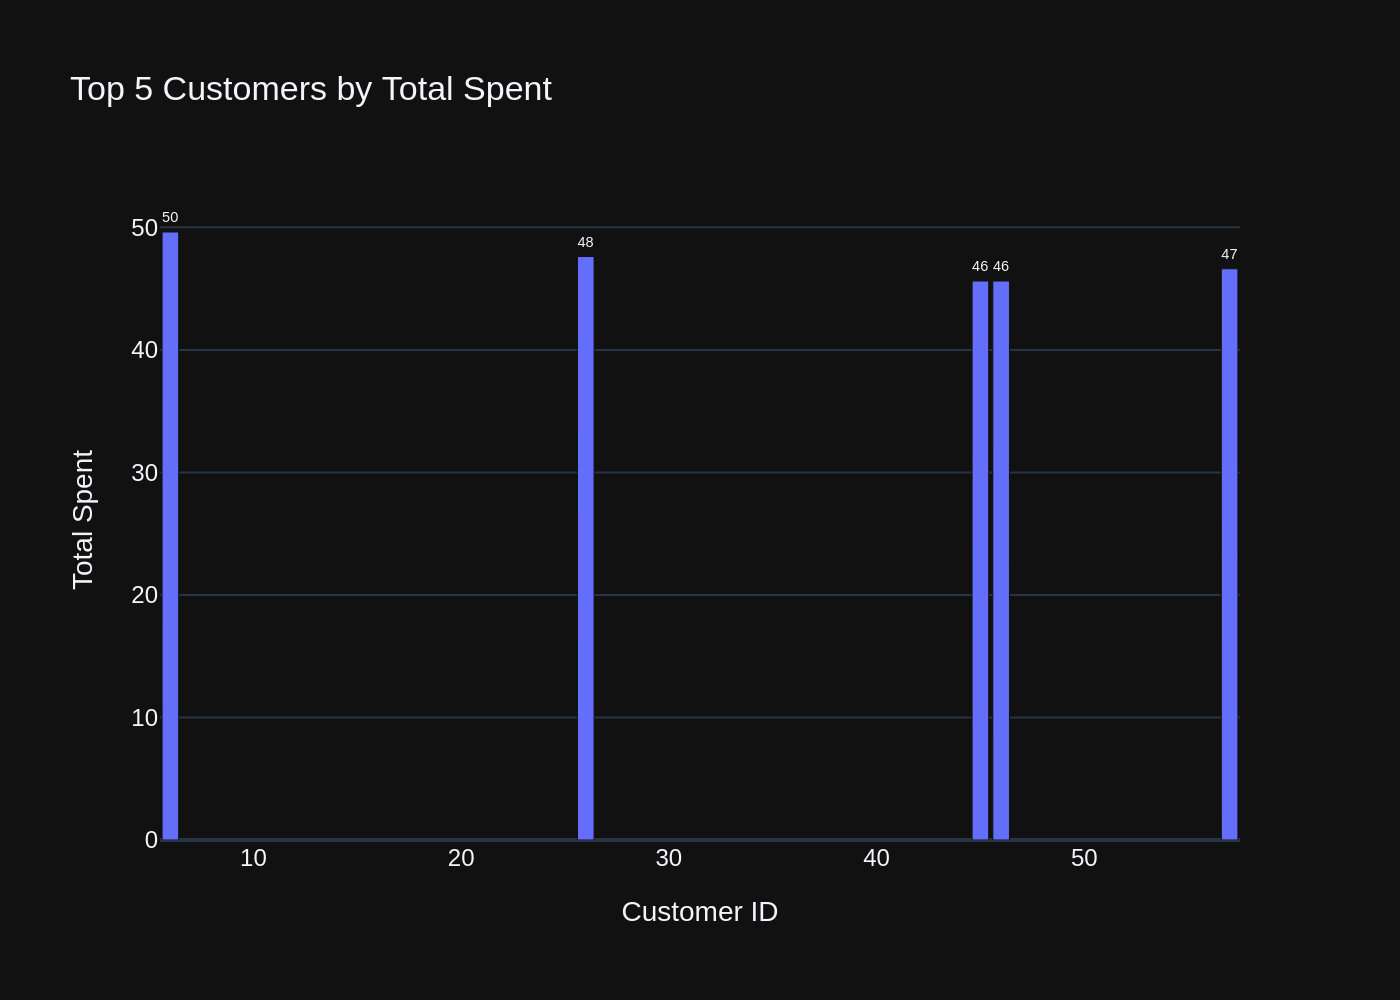





# QUESTION  - 24:  Get all playlists containing at least 10 tracks and the total duration of those tracks:


Using model gpt-4o for 1310.25 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT p.PlaylistId, p.Name, COUNT(pt.TrackId) AS NumberOfTracks, SUM(t.Milliseconds) AS TotalDuration
FROM playlists p
JOIN playlist_track pt ON p.PlaylistId = pt.PlaylistId
JOIN tracks t ON pt.TrackId = t.TrackId
GROUP BY p.PlaylistId
HAVING NumberOfTracks >= 10 LIMIT 20


[( <DataFrame> )]
queried dataframe



,PlaylistId,Name,NumberOfTracks,TotalDuration
0,1,Music,3290,877683083
1,3,TV Shows,213,501094957
2,5,90’s Music,1477,398705153
3,8,Music,3290,877683083
4,10,TV Shows,213,501094957
5,11,Brazilian Music,39,9486559
6,12,Classical,75,21770592
7,13,Classical 101 - Deep Cuts,25,6755730
8,14,Classical 101 - Next Steps,25,7575051
9,15,Classical 101 - The Basics,25,7439811


Using model gpt-4o for 255.0 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.express as px
import plotly.graph_objects as go

if len(df) == 1:
    fig = go.Figure(go.Indicator(
        mode = "number",
        value = df['TotalDuration'].iloc[0],
        title = {"text": f"Total Duration of Playlist '{df['Name'].iloc[0]}'"},
        number = {'suffix': " ms"}
    ))
else:
    fig = px.bar(df, x='Name', y='TotalDuration', 
                 hover_data=['NumberOfTracks'], 
                 labels={'TotalDuration':'Total Duration (ms)', 'Name':'Playlist Name'},
                 title='Total Duration of Playlists with at Least 10 Tracks')
    fig.update_layout(xaxis_title='Playlist Name', yaxis_title='Total Duration (ms)')

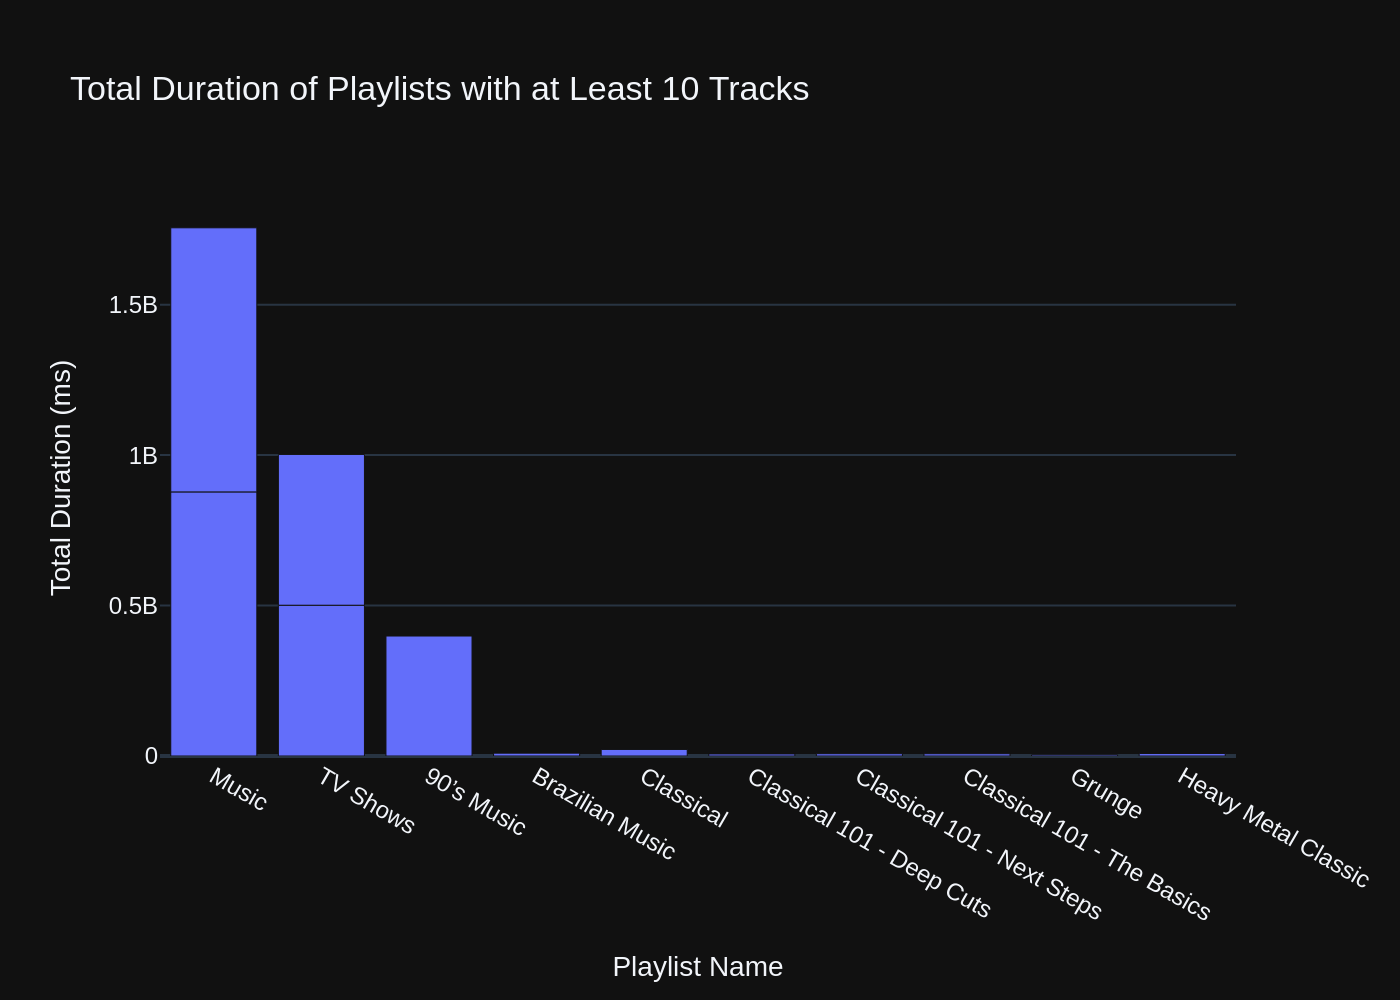





# QUESTION  - 25:  Identify artists who have albums with tracks appearing in multiple genres:


Using model gpt-4o for 1349.5 tokens (approx)

[( EXTRACTED SQL )]
SELECT DISTINCT ar.Name AS ArtistName
FROM artists ar
JOIN albums al ON ar.ArtistId = al.ArtistId
JOIN tracks t ON al.AlbumId = t.AlbumId
GROUP BY ar.ArtistId, al.AlbumId
HAVING COUNT(DISTINCT t.GenreId) > 1 LIMIT 20;


[( <SQL> )]
generated SQL statement



SELECT DISTINCT ar.Name AS ArtistName
FROM artists ar
JOIN albums al ON ar.ArtistId = al.ArtistId
JOIN tracks t ON al.AlbumId = t.AlbumId
GROUP BY ar.ArtistId, al.AlbumId
HAVING COUNT(DISTINCT t.GenreId) > 1 LIMIT 20;


[( <DataFrame> )]
queried dataframe



,ArtistName
0,Eric Clapton
1,Iron Maiden
2,Lenny Kravitz
3,Battlestar Galactica
4,Heroes
5,Lost
6,The Office


Using model gpt-4o for 218.0 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.express as px
import plotly.graph_objects as go

if len(df) == 1:
    fig = go.Figure(go.Indicator(
        mode = "number",
        value = len(df),
        title = {"text": "Number of Artists with Albums in Multiple Genres"}
    ))
else:
    fig = px.bar(df, x='ArtistName', y=df.index, orientation='h', 
                 labels={'y': 'Number of Artists', 'ArtistName': 'Artist Name'},
                 title='Artists with Albums in Multiple Genres')
    fig.update_layout(yaxis={'categoryorder':'total ascending'})

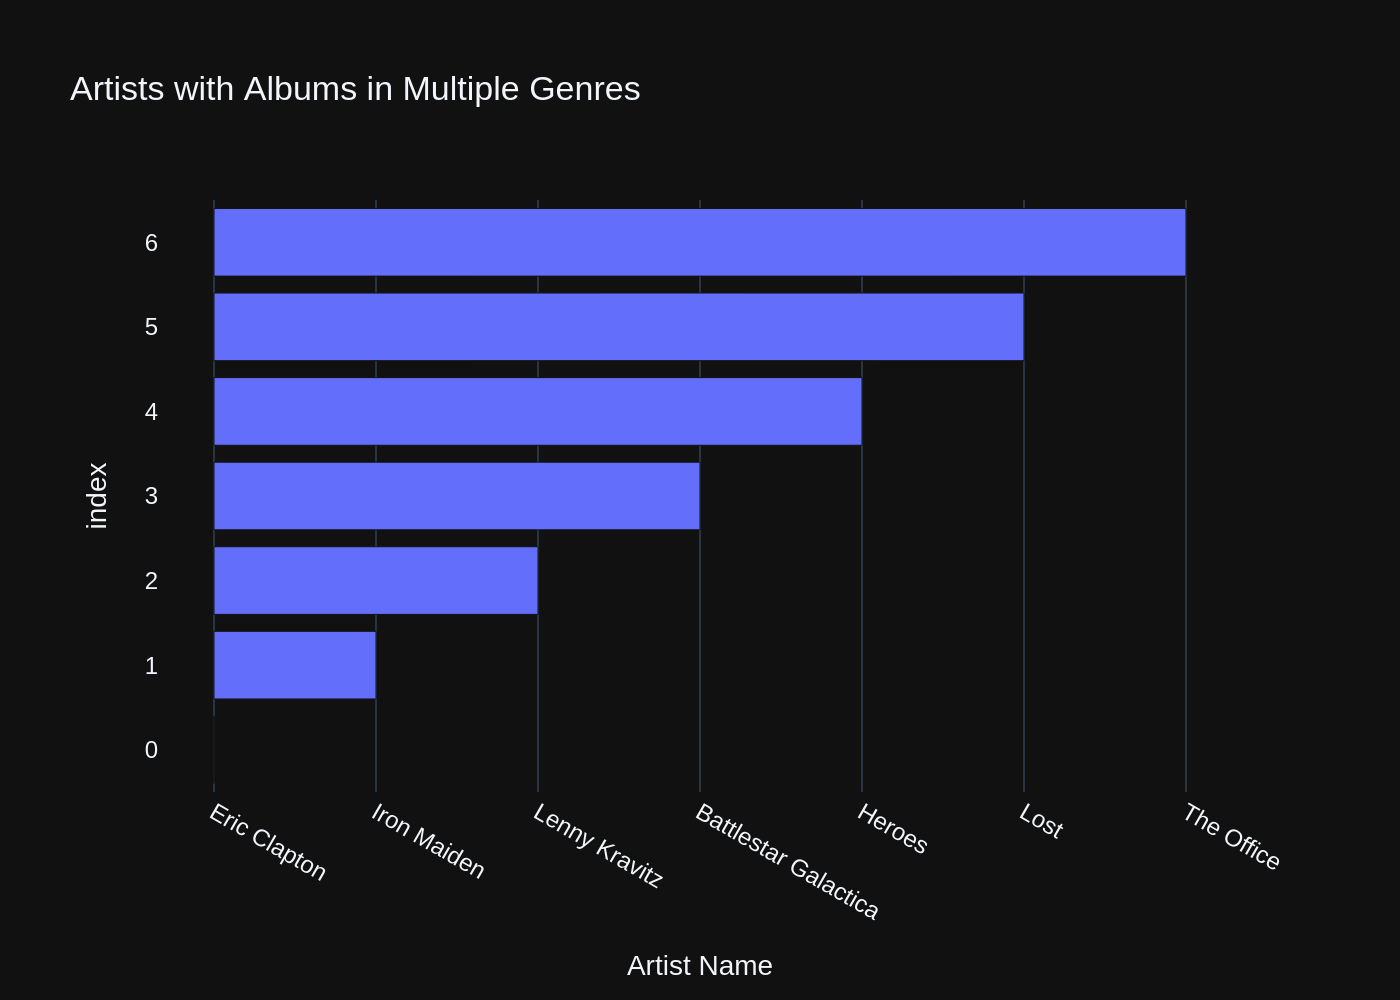

In [18]:
ts_start = time()
for n, question in enumerate(questions):
    # if n != 4: continue
    # if n > 5: continue

    resp = vn.ask_adaptive(question=question, tag_id=n+2)
    # vn.ask(question=question, allow_llm_to_see_data=allow_llm_to_see_data)
    # my_vn_ask(question=question, sql_id=n+2, allow_llm_to_see_data=allow_llm_to_see_data)

ts_stop = time()
elapsed_time = ts_stop - ts_start

## Check completion time

In [19]:
str_elapsed_sec = f"{elapsed_time:.0f}"
ts = datetime.now().strftime("%Y%m%d-%H%M%S")
print(f"Completed testing:\n================\n LLM model '{model_name}' \n took {str_elapsed_sec} sec\n run on '{hostname}' \n at {ts}")

Completed testing:
 LLM model 'gpt-4o' 
 took 105 sec
 run on 'ducklover1' 
 at 20241122-232835


In [20]:
file_csv = f"training_data-{model_name}-{str_elapsed_sec}s-{hostname}-{ts}.csv"
file_csv

'training_data-gpt-4o-105s-ducklover1-20241122-232835.csv'

### Save training data

In [21]:
# show training data
df_training_data = vn.get_training_data()
df_training_data

,id,question,content,training_data_type
0,03adcda0-2a91-5e32-8e9c-0edc94cb7f83-sql,List all genres and the number of tracks in ea...,"SELECT g.Name AS GenreName, COUNT(t.TrackId) A...",sql
1,1274052b-0b10-54f8-a044-94bd0c6b6955-sql,How many customers are there,SELECT COUNT(*) AS NumberOfCustomers FROM cust...,sql
2,15aac60e-cb46-5006-b812-57ce43a744d4-sql,"Find all tracks with a name containing ""What"" ...",SELECT * FROM tracks WHERE Name LIKE '%What%' ...,sql
3,198be005-3d10-5b95-8e39-9a73ae76e6bc-sql,List all invoices with a total exceeding $10,SELECT * FROM invoices WHERE Total > 10 LIMIT 20,sql
4,359131a3-86c4-5ed9-8798-de203b4c00e0-sql,List all customers from Canada and their email...,"SELECT FirstName, LastName, Email\nFROM custom...",sql
5,3b1cadec-0bcc-5b51-aa0d-eadd8dad6fdb-sql,Identify artists who have albums with tracks a...,SELECT DISTINCT ar.Name AS ArtistName\nFROM ar...,sql
6,4e077a4f-a3f2-5b66-8a81-3db5aa199d8f-sql,Find the customer who bought the most albums i...,"SELECT i.CustomerId, SUM(ii.Quantity) AS Total...",sql
7,584f7b5b-eecb-5b90-a56b-dc42f4b8114a-sql,\n Can you find the top 10 most popula...,"SELECT ar.Name AS ArtistName, COUNT(t.TrackId)...",sql
8,5a31a528-5ffb-562b-a32a-b4cc63040bfe-sql,List all albums and their corresponding artist...,"SELECT albums.Title AS AlbumTitle, artists.Nam...",sql
9,603169f7-b26b-5b3d-8765-efad751d52ac-sql,\n Find the top 5 customers who spen...,"SELECT CustomerId, SUM(Total) AS TotalSpent\nF...",sql


In [22]:
df_training_data.to_csv(file_csv, index=False)